Loading data...
Loaded 132 rows
Columns: ['Subject', 'Group', 'Surgery_Side', 'Intact_Hemisphere', 'Sex', 'nonpt_hemi', 'Category', 'Category_Type', 'age_1', 'age_2', 'yr_gap', 'Selectivity_Change', 'Spatial_Relocation_mm', 'Geometry_Preservation_6mm', 'Geometry_Preservation_8mm', 'Geometry_Preservation_10mm', 'Anchored_Stability_6mm', 'MDS_Shift']

After exclusions: 108 rows
Subjects remaining: 20

Conditions: ['OTC (Left)', 'OTC (Right)', 'control (L)', 'control (R)', 'nonOTC (Left)', 'nonOTC (Right)']

Creating plot...
Plot saved to: /user_data/csimmon2/long_pt/plots/mds_shift_by_category_hemisphere.png


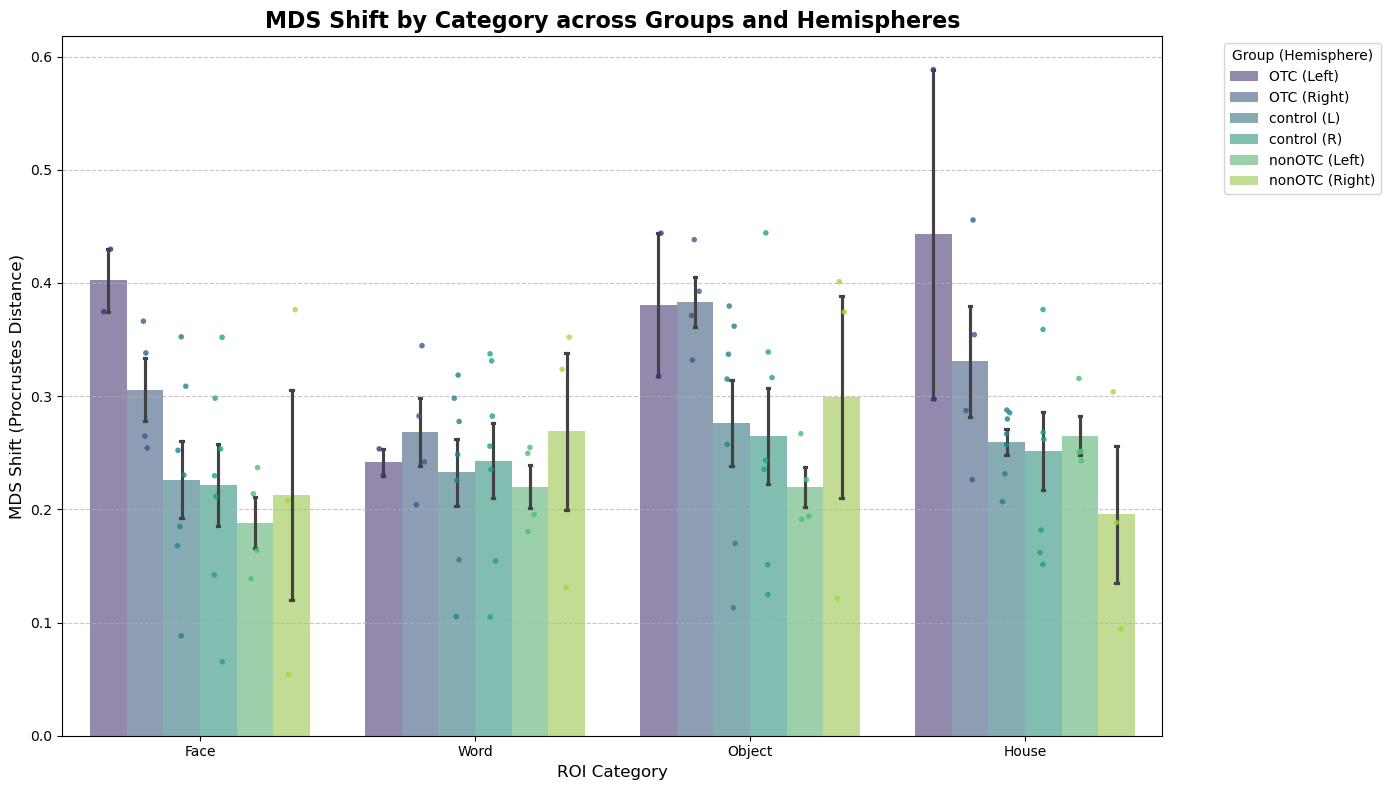


SUMMARY STATISTICS

By Group and Category Type:
                           mean       std  count
Group   Category_Type                           
OTC     Bilateral      0.375425  0.096578     12
        Unilateral     0.298684  0.069762     12
control Bilateral      0.262985  0.084786     28
        Unilateral     0.230972  0.082940     28
nonOTC  Bilateral      0.244436  0.086458     14
        Unilateral     0.219850  0.088847     14

By Condition and Category:
                             mean       std  count
Condition      Category                           
OTC (Left)     Face      0.402193  0.039066      2
               House     0.443016  0.205731      2
               Object    0.380770  0.089434      2
               Word      0.241651  0.016638      2
OTC (Right)    Face      0.305840  0.054923      4
               House     0.330849  0.098283      4
               Object    0.383533  0.044322      4
               Word      0.268289  0.060129      4
control (L)    Face  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# =============================================================================
# SETUP: Paths and Configuration
# =============================================================================

# Set your base directory - MODIFY THIS to match your system
BASE_DIR = Path("/user_data/csimmon2/long_pt")

# Input file path
INPUT_CSV = "/user_data/csimmon2/git_repos/long_pt/results_final_corrected.csv"  # or whatever your file is named

# Output directory for plots
OUTPUT_DIR = BASE_DIR / "plots"
OUTPUT_DIR.mkdir(exist_ok=True)

# Plotting configuration
plt.style.use('default')
sns.set_palette("viridis")

# =============================================================================
# LOAD DATA
# =============================================================================

print("Loading data...")
df = pd.read_csv(INPUT_CSV)
print(f"Loaded {len(df)} rows")
print(f"Columns: {df.columns.tolist()}\n")

# =============================================================================
# DATA PROCESSING
# =============================================================================

# 1. Extract MDS values (already matched in the CSV)
df['MDS'] = df['MDS_Shift']

# 2. Get hemisphere information
def get_hemi(row):
    """Extract hemisphere based on group"""
    if row['Group'] == 'control':
        h = row['nonpt_hemi']  # 'R' or 'L'
    else:
        h = row['Intact_Hemisphere']  # 'left' or 'right'
    return h.lower().capitalize()  # Standardize to 'Left' or 'Right'

df['Hemisphere'] = df.apply(get_hemi, axis=1)

# 3. Create condition labels for plotting
df['Condition'] = df['Group'] + " (" + df['Hemisphere'] + ")"

# 4. Apply exclusions
exclusions = ['control025', 'control027', 'nonOTC045', 'nonOTC072']
df_filtered = df[~df['Subject'].isin(exclusions)].copy()

print(f"After exclusions: {len(df_filtered)} rows")
print(f"Subjects remaining: {df_filtered['Subject'].nunique()}")
print(f"\nConditions: {sorted(df_filtered['Condition'].unique())}\n")

# =============================================================================
# PLOTTING
# =============================================================================

print("Creating plot...")

plt.figure(figsize=(14, 8))

# Define order for consistent coloring
hue_order = sorted(df_filtered['Condition'].unique())

# Define category order
category_order = ['Face', 'Word', 'Object', 'House']

# Bar plot with error bars
ax = sns.barplot(
    data=df_filtered, 
    x="Category", 
    y="MDS", 
    hue="Condition",
    palette="viridis", 
    alpha=0.6, 
    errorbar="se",  # Standard error
    capsize=0.05,
    hue_order=hue_order,
    order=category_order
)

# Overlay individual data points
sns.stripplot(
    data=df_filtered, 
    x="Category", 
    y="MDS", 
    hue="Condition",
    palette="viridis", 
    dodge=True, 
    ax=ax, 
    alpha=0.8, 
    jitter=True, 
    size=4, 
    legend=False, 
    hue_order=hue_order,
    order=category_order
)

# Formatting
plt.title("MDS Shift by Category across Groups and Hemispheres", fontsize=16, fontweight='bold')
plt.ylabel("MDS Shift (Procrustes Distance)", fontsize=12)
plt.xlabel("ROI Category", fontsize=12)
plt.legend(title="Group (Hemisphere)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save plot
output_file = OUTPUT_DIR / 'mds_shift_by_category_hemisphere.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {output_file}")

plt.show()

# =============================================================================
# SUMMARY STATISTICS
# =============================================================================

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

# By Group and Category Type
summary = df_filtered.groupby(['Group', 'Category_Type'])['MDS'].agg(['mean', 'std', 'count'])
print("\nBy Group and Category Type:")
print(summary)

# By Condition and Category
summary_cond = df_filtered.groupby(['Condition', 'Category'])['MDS'].agg(['mean', 'std', 'count'])
print("\nBy Condition and Category:")
print(summary_cond)

print("\n" + "="*80)

# New attempt to calculate selectivity

In [33]:
# =============================================================================
# CELL 1: CONFIGURATION AND SETUP
# =============================================================================

BASE_DIR = Path("/user_data/csimmon2/long_pt")
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
OUTPUT_DIR = BASE_DIR / "hemisphere_dominance_analysis"
OUTPUT_DIR.mkdir(exist_ok=True)

# Session configuration
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

# Category to cope mapping - CORRECTED to use "Category > All others"
COPE_MAP = {
    'face': 6,     # Face > All others
    'word': 9,     # Word > All others (was 13 = Word > Face - WRONG!)
    'object': 8,   # Object > All others
    'house': 7     # House > All others
}

# Z-score threshold
THRESH = 2.3

def get_first_session(sub):
    """Get first session number for subject"""
    return SESSION_START.get(sub, 1)

print("✓ Configuration loaded")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Threshold: {THRESH}")
print(f"  Using 'Category > All others' contrasts:")
for cat, cope in COPE_MAP.items():
    print(f"    {cat}: cope {cope}")

✓ Configuration loaded
  Output directory: /user_data/csimmon2/long_pt/hemisphere_dominance_analysis
  Threshold: 2.3
  Using 'Category > All others' contrasts:
    face: cope 6
    word: cope 9
    object: cope 8
    house: cope 7


In [35]:
# =============================================================================
# CELL 2A: CALCULATE HEMISPHERE SELECTIVITY - ALL CONTRAST SCHEMES
# =============================================================================

# Define three contrast schemes
CONTRAST_SCHEMES = {
    'category_vs_all': {
        'face': 6,     # Face > All others
        'word': 9,     # Word > All others
        'object': 8,   # Object > All others
        'house': 7     # House > All others
    },
    'category_vs_scramble': {
        'face': 10,    # Face > Scramble
        'word': 12,    # Word > Scramble
        'object': 3,   # Object > Scramble
        'house': 11    # House > Scramble
    },
    'original_incorrect': {
        'face': 10,    # Face > Scramble
        'word': 13,    # Word > Face (WRONG!)
        'object': 3,   # Object > Scramble
        'house': 11    # House > Scramble
    }
}

def calc_hemisphere_selectivity_v2(sub, ses, category, hemisphere, group, intact_hemi, cope_num):
    """
    Calculate sum selectivity for a given hemisphere using specified cope number
    """
    ses_str = f"{ses:02d}"
    
    # Skip if OTC/nonOTC patient and requesting non-intact hemisphere
    if group in ['OTC', 'nonOTC']:
        if hemisphere != intact_hemi.lower():
            return {'sum_selectivity': None, 'n_voxels': None, 'mean_activation': None,
                    'error': f'Patient only has {intact_hemi} hemisphere (skipping {hemisphere})'}
    
    # Path to z-stat file
    first_ses = get_first_session(sub)
    first_ses_str = f"{first_ses:02d}"
    
    zstat_first = BASE_DIR / sub / f'ses-{ses_str}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / f'zstat1_ses{first_ses_str}.nii.gz'
    zstat_native = BASE_DIR / sub / f'ses-{ses_str}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    zstat = zstat_first if zstat_first.exists() else zstat_native
    
    # Path to ROI mask
    hemi_letter = hemisphere[0]
    roi_file = BASE_DIR / sub / f'ses-{ses_str}' / 'ROIs' / f'{hemi_letter}_{category}_searchmask.nii.gz'
    
    if not zstat.exists():
        return {'sum_selectivity': None, 'n_voxels': None, 'mean_activation': None, 
                'error': f'zstat not found'}
    
    if not roi_file.exists():
        return {'sum_selectivity': None, 'n_voxels': None, 'mean_activation': None,
                'error': f'ROI mask not found'}
    
    try:
        func = image.load_img(str(zstat))
        func_thresh = image.threshold_img(func, threshold=THRESH)
        mask = image.load_img(str(roi_file))
        vox_resp = masking.apply_mask(func_thresh, mask)
        vox_resp = vox_resp[vox_resp > 0]
        
        if len(vox_resp) > 0:
            sum_selec = float(np.sum(vox_resp))
            n_voxels = len(vox_resp)
            mean_act = float(np.mean(vox_resp))
        else:
            sum_selec = 0.0
            n_voxels = 0
            mean_act = 0.0
        
        return {
            'sum_selectivity': sum_selec,
            'n_voxels': n_voxels,
            'mean_activation': mean_act,
            'error': None
        }
        
    except Exception as e:
        return {'sum_selectivity': None, 'n_voxels': None, 'mean_activation': None,
                'error': str(e)}

# Calculate for all three schemes
all_results = {}

sub_info = pd.read_csv(CSV_FILE)

for scheme_name, cope_map in CONTRAST_SCHEMES.items():
    print("\n" + "="*80)
    print(f"CALCULATING: {scheme_name.upper().replace('_', ' ')}")
    print("="*80)
    print("Cope mapping:")
    for cat, cope in cope_map.items():
        print(f"  {cat}: cope {cope}")
    
    results = []
    
    for _, row in sub_info.iterrows():
        sub = row['sub']
        group = row['group']
        intact_hemi = str(row.get('intact_hemi', 'both')).lower()
        first_ses = get_first_session(sub)
        
        print(f"\nProcessing {sub} (group: {group}, intact: {intact_hemi})")
        
        for category in ['face', 'word', 'object', 'house']:
            cope_num = cope_map[category]
            
            for hemisphere in ['left', 'right']:
                print(f"  {category} (cope{cope_num}) - {hemisphere}...", end=" ")
                
                metrics = calc_hemisphere_selectivity_v2(sub, first_ses, category, hemisphere, 
                                                        group, intact_hemi, cope_num)
                
                if metrics['error']:
                    if 'skipping' in metrics['error']:
                        print(f"Skipped (patient)")
                    else:
                        print(f"Error: {metrics['error']}")
                else:
                    print(f"Sum: {metrics['sum_selectivity']:.1f}, n={metrics['n_voxels']}")
                
                results.append({
                    'subject': sub,
                    'group': group,
                    'intact_hemi': intact_hemi,
                    'category': category,
                    'hemisphere': hemisphere,
                    'sum_selectivity': metrics['sum_selectivity'],
                    'n_voxels': metrics['n_voxels'],
                    'mean_activation': metrics['mean_activation'],
                    'error': metrics['error'],
                    'contrast_scheme': scheme_name,
                    'cope_num': cope_num
                })
    
    # Save results for this scheme
    df = pd.DataFrame(results)
    output_file = OUTPUT_DIR / f'hemisphere_selectivity_{scheme_name}.csv'
    df.to_csv(output_file, index=False)
    print(f"\n✓ Results saved to: {output_file}")
    
    all_results[scheme_name] = df

print("\n" + "="*80)
print("ALL SCHEMES CALCULATED")
print("="*80)


CALCULATING: CATEGORY VS ALL
Cope mapping:
  face: cope 6
  word: cope 9
  object: cope 8
  house: cope 7

Processing sub-004 (group: OTC, intact: left)
  face (cope6) - left... Sum: 944.0, n=338
  face (cope6) - right... Skipped (patient)
  word (cope9) - left... Sum: 65.1, n=26
  word (cope9) - right... Skipped (patient)
  object (cope8) - left... Sum: 18392.5, n=5489
  object (cope8) - right... Skipped (patient)
  house (cope7) - left... Sum: 10087.3, n=3054
  house (cope7) - right... Skipped (patient)

Processing sub-007 (group: nonOTC, intact: right)
  face (cope6) - left... Skipped (patient)
  face (cope6) - right... Sum: 24407.3, n=6017
  word (cope9) - left... Skipped (patient)
  word (cope9) - right... Sum: 82.2, n=27
  object (cope8) - left... Skipped (patient)
  object (cope8) - right... Sum: 20578.0, n=6529
  house (cope7) - left... Skipped (patient)
  house (cope7) - right... Sum: 27311.3, n=6864

Processing sub-008 (group: OTC, intact: left)
  face (cope6) - left... Sum:

In [36]:
# =============================================================================
# CELL 2B: COMPARE HEMISPHERE DOMINANCE ACROSS CONTRAST SCHEMES
# =============================================================================

print("="*80)
print("COMPARING HEMISPHERE DOMINANCE - ALL CONTRAST SCHEMES")
print("="*80)

comparison_summary = []

for scheme_name, df in all_results.items():
    print(f"\n{'='*80}")
    print(f"{scheme_name.upper().replace('_', ' ')}")
    print(f"{'='*80}")
    
    # Filter to controls only
    controls = df[(df['group'] == 'control') & (df['sum_selectivity'].notna())]
    
    for category in ['face', 'word', 'object', 'house']:
        cat_data = controls[controls['category'] == category]
        
        left = cat_data[cat_data['hemisphere'] == 'left']['sum_selectivity']
        right = cat_data[cat_data['hemisphere'] == 'right']['sum_selectivity']
        
        left_mean = left.mean()
        right_mean = right.mean()
        
        if left_mean > right_mean:
            dominant = 'left'
            ratio = left_mean / right_mean if right_mean > 0 else float('inf')
        else:
            dominant = 'right'
            ratio = right_mean / left_mean if left_mean > 0 else float('inf')
        
        print(f"\n{category.upper()}:")
        print(f"  Left:  {left_mean:7.1f} (n={len(left)})")
        print(f"  Right: {right_mean:7.1f} (n={len(right)})")
        print(f"  Dominant: {dominant.upper()} (ratio: {ratio:.2f}x)")
        
        comparison_summary.append({
            'contrast_scheme': scheme_name,
            'category': category,
            'left_mean': left_mean,
            'right_mean': right_mean,
            'dominant_hemisphere': dominant,
            'dominance_ratio': ratio
        })

# Create comparison table
comparison_df = pd.DataFrame(comparison_summary)
comparison_pivot = comparison_df.pivot_table(
    index='category',
    columns='contrast_scheme',
    values='dominant_hemisphere',
    aggfunc='first'
)

print("\n" + "="*80)
print("DOMINANCE COMPARISON TABLE")
print("="*80)
print(comparison_pivot)

# Save comparison
output_file = OUTPUT_DIR / 'hemisphere_dominance_comparison_all_schemes.csv'
comparison_df.to_csv(output_file, index=False)
print(f"\n✓ Comparison saved to: {output_file}")

COMPARING HEMISPHERE DOMINANCE - ALL CONTRAST SCHEMES

CATEGORY VS ALL

FACE:
  Left:  16313.0 (n=9)
  Right: 19917.0 (n=9)
  Dominant: RIGHT (ratio: 1.22x)

WORD:
  Left:  12117.0 (n=9)
  Right:  1197.3 (n=9)
  Dominant: LEFT (ratio: 10.12x)

OBJECT:
  Left:  40485.5 (n=9)
  Right: 37547.8 (n=9)
  Dominant: LEFT (ratio: 1.08x)

HOUSE:
  Left:  39905.7 (n=9)
  Right: 39542.1 (n=9)
  Dominant: LEFT (ratio: 1.01x)

CATEGORY VS SCRAMBLE

FACE:
  Left:  24876.9 (n=9)
  Right: 25423.6 (n=9)
  Dominant: RIGHT (ratio: 1.02x)

WORD:
  Left:  22936.7 (n=9)
  Right:  7432.9 (n=9)
  Dominant: LEFT (ratio: 3.09x)

OBJECT:
  Left:  41289.8 (n=9)
  Right: 39012.2 (n=9)
  Dominant: LEFT (ratio: 1.06x)

HOUSE:
  Left:  29854.7 (n=9)
  Right: 28910.3 (n=9)
  Dominant: LEFT (ratio: 1.03x)

ORIGINAL INCORRECT

FACE:
  Left:  24876.9 (n=9)
  Right: 25423.6 (n=9)
  Dominant: RIGHT (ratio: 1.02x)

WORD:
  Left:   5426.2 (n=9)
  Right:  8476.4 (n=9)
  Dominant: RIGHT (ratio: 1.56x)

OBJECT:
  Left:  41289.8 

In [37]:
# Quick check: do parcel sizes differ between hemispheres?
parcel_sizes = []

for _, row in sub_info.iterrows():
    sub = row['sub']
    first_ses = get_first_session(sub)
    ses_str = f"{first_ses:02d}"
    
    for category in ['face', 'word', 'object', 'house']:
        for hemisphere in ['left', 'right']:
            hemi_letter = hemisphere[0]
            roi_file = BASE_DIR / sub / f'ses-{ses_str}' / 'ROIs' / f'{hemi_letter}_{category}_searchmask.nii.gz'
            
            if roi_file.exists():
                mask_img = image.load_img(str(roi_file))
                roi_size = int(np.sum(mask_img.get_fdata() > 0))
                parcel_sizes.append({
                    'subject': sub,
                    'category': category,
                    'hemisphere': hemisphere,
                    'parcel_size': roi_size
                })

parcel_df = pd.DataFrame(parcel_sizes)
print(parcel_df.groupby(['category', 'hemisphere'])['parcel_size'].agg(['mean', 'std']))

                             mean          std
category hemisphere                           
face     left        18166.750000  2279.206046
         right       17566.941176  3747.820258
house    left        23846.562500  3605.128975
         right       21800.058824  3252.259608
object   left        24014.375000  3197.109087
         right       24077.823529  3571.053280
word     left        18166.750000  2279.206046
         right       17566.941176  3747.820258


In [34]:
# =============================================================================
# CELL 2_old: CALCULATE HEMISPHERE SELECTIVITY (USING ROI MASKS)
# =============================================================================

def calc_hemisphere_selectivity(sub, ses, category, hemisphere, group, intact_hemi):
    """
    Calculate sum selectivity for a given hemisphere using ROI masks
    
    Parameters:
    -----------
    sub : str
        Subject ID (e.g., 'sub-004')
    ses : int
        Session number
    category : str
        Category name ('face', 'word', 'object', 'house')
    hemisphere : str
        'left' or 'right'
    group : str
        'control', 'OTC', or 'nonOTC'
    intact_hemi : str
        For patients: 'left' or 'right'. For controls: 'both'
    
    Returns:
    --------
    dict with sum_selectivity, n_voxels, mean_activation
    """
    cope_num = COPE_MAP[category]
    ses_str = f"{ses:02d}"
    
    # Skip if patient and requesting non-intact hemisphere
    if group in ['OTC', 'nonOTC']:
        if hemisphere != intact_hemi.lower():
            return {'sum_selectivity': None, 'n_voxels': None, 'mean_activation': None,
                    'error': f'Patient only has {intact_hemi} hemisphere (skipping {hemisphere})'}
    
    # Path to z-stat file (use first-session registered version if available)
    first_ses = get_first_session(sub)
    first_ses_str = f"{first_ses:02d}"
    
    zstat_first = BASE_DIR / sub / f'ses-{ses_str}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / f'zstat1_ses{first_ses_str}.nii.gz'
    zstat_native = BASE_DIR / sub / f'ses-{ses_str}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    # Use first-session space if available, otherwise native
    zstat = zstat_first if zstat_first.exists() else zstat_native
    
    # Path to ROI mask - using category-specific anatomical parcels
    hemi_letter = hemisphere[0]  # 'l' or 'r'
    roi_file = BASE_DIR / sub / f'ses-{ses_str}' / 'ROIs' / f'{hemi_letter}_{category}_searchmask.nii.gz'
    
    if not zstat.exists():
        return {'sum_selectivity': None, 'n_voxels': None, 'mean_activation': None, 
                'error': f'zstat not found'}
    
    if not roi_file.exists():
        return {'sum_selectivity': None, 'n_voxels': None, 'mean_activation': None,
                'error': f'ROI mask not found'}
    
    try:
        # Load and threshold functional data
        func = image.load_img(str(zstat))
        func_thresh = image.threshold_img(func, threshold=THRESH)
        
        # Load ROI mask
        mask = image.load_img(str(roi_file))
        
        # Extract voxel values
        vox_resp = masking.apply_mask(func_thresh, mask)
        vox_resp = vox_resp[vox_resp > 0]  # Keep only active voxels
        
        # Calculate metrics
        if len(vox_resp) > 0:
            sum_selec = float(np.sum(vox_resp))
            n_voxels = len(vox_resp)
            mean_act = float(np.mean(vox_resp))
        else:
            sum_selec = 0.0
            n_voxels = 0
            mean_act = 0.0
        
        return {
            'sum_selectivity': sum_selec,
            'n_voxels': n_voxels,
            'mean_activation': mean_act,
            'error': None
        }
        
    except Exception as e:
        return {'sum_selectivity': None, 'n_voxels': None, 'mean_activation': None,
                'error': str(e)}

# Run the calculation
print("="*80)
print("CALCULATING HEMISPHERE SELECTIVITY (USING ROI MASKS)")
print("="*80)

# Load subject info
sub_info = pd.read_csv(CSV_FILE)

results = []

for _, row in sub_info.iterrows():
    sub = row['sub']
    group = row['group']
    intact_hemi = str(row.get('intact_hemi', 'both')).lower()
    
    # Get first session
    first_ses = get_first_session(sub)
    
    print(f"\nProcessing {sub} (group: {group}, intact: {intact_hemi}, session: {first_ses})")
    
    for category in ['face', 'word', 'object', 'house']:
        for hemisphere in ['left', 'right']:
            print(f"  {category} - {hemisphere}...", end=" ")
            
            metrics = calc_hemisphere_selectivity(sub, first_ses, category, hemisphere, group, intact_hemi)
            
            if metrics['error']:
                if 'skipping' in metrics['error']:
                    print(f"Skipped (patient)")
                else:
                    print(f"Error: {metrics['error']}")
            else:
                print(f"Sum: {metrics['sum_selectivity']:.1f}, n={metrics['n_voxels']}")
            
            results.append({
                'subject': sub,
                'group': group,
                'intact_hemi': intact_hemi,
                'category': category,
                'hemisphere': hemisphere,
                'sum_selectivity': metrics['sum_selectivity'],
                'n_voxels': metrics['n_voxels'],
                'mean_activation': metrics['mean_activation'],
                'error': metrics['error']
            })

# Create DataFrame
selectivity_df = pd.DataFrame(results)

# Save raw results
output_file = OUTPUT_DIR / 'hemisphere_selectivity_raw_ROI_based.csv'
selectivity_df.to_csv(output_file, index=False)
print(f"\n✓ Raw results saved to: {output_file}")

# Quick summary
print("\nData summary:")
print(f"  Total rows: {len(selectivity_df)}")
print(f"  Valid data: {selectivity_df['sum_selectivity'].notna().sum()}")
print(f"  Errors: {selectivity_df['error'].notna().sum()}")

CALCULATING HEMISPHERE SELECTIVITY (USING ROI MASKS)

Processing sub-004 (group: OTC, intact: left, session: 1)
  face - left... Sum: 944.0, n=338
  face - right... Skipped (patient)
  word - left... Sum: 65.1, n=26
  word - right... Skipped (patient)
  object - left... Sum: 18392.5, n=5489
  object - right... Skipped (patient)
  house - left... Sum: 10087.3, n=3054
  house - right... Skipped (patient)

Processing sub-007 (group: nonOTC, intact: right, session: 1)
  face - left... Skipped (patient)
  face - right... Sum: 24407.3, n=6017
  word - left... Skipped (patient)
  word - right... Sum: 82.2, n=27
  object - left... Skipped (patient)
  object - right... Sum: 20578.0, n=6529
  house - left... Skipped (patient)
  house - right... Sum: 27311.3, n=6864

Processing sub-008 (group: OTC, intact: left, session: 1)
  face - left... Sum: 53121.9, n=8559
  face - right... Skipped (patient)
  word - left... Sum: 212.8, n=73
  word - right... Skipped (patient)
  object - left... Sum: 20137.3

In [17]:
# =============================================================================
# CELL 3: ANALYZE HEMISPHERE DOMINANCE (CONTROLS ONLY)
# =============================================================================

print("\n" + "="*80)
print("HEMISPHERE DOMINANCE ANALYSIS - CONTROLS ONLY")
print("="*80)

# Load the data from Cell 2 (if running separately)
# selectivity_df = pd.read_csv(OUTPUT_DIR / 'hemisphere_selectivity_raw.csv')

# Filter to controls only and valid data
controls = selectivity_df[(selectivity_df['group'] == 'control') & 
                          (selectivity_df['sum_selectivity'].notna())]

print(f"\nAnalyzing {len(controls)} control measurements")

dominance_results = []

for category in ['face', 'word', 'object', 'house']:
    cat_data = controls[controls['category'] == category]
    
    # Calculate mean sum selectivity per hemisphere
    left = cat_data[cat_data['hemisphere'] == 'left']['sum_selectivity']
    right = cat_data[cat_data['hemisphere'] == 'right']['sum_selectivity']
    
    left_mean = left.mean()
    right_mean = right.mean()
    left_std = left.std()
    right_std = right.std()
    left_n = len(left)
    right_n = len(right)
    
    # Determine dominance
    if left_mean > right_mean:
        dominant = 'left'
        ratio = left_mean / right_mean if right_mean > 0 else float('inf')
    else:
        dominant = 'right'
        ratio = right_mean / left_mean if left_mean > 0 else float('inf')
    
    print(f"\n{category.upper()}:")
    print(f"  Left:  {left_mean:7.1f} ± {left_std:6.1f} (n={left_n})")
    print(f"  Right: {right_mean:7.1f} ± {right_std:6.1f} (n={right_n})")
    print(f"  Dominant: {dominant.upper()} (ratio: {ratio:.2f}x)")
    
    dominance_results.append({
        'category': category,
        'left_mean': left_mean,
        'left_std': left_std,
        'left_n': left_n,
        'right_mean': right_mean,
        'right_std': right_std,
        'right_n': right_n,
        'dominant_hemisphere': dominant,
        'dominance_ratio': ratio
    })

# Save dominance summary
dominance_df = pd.DataFrame(dominance_results)
output_file = OUTPUT_DIR / 'hemisphere_dominance_controls_summary.csv'
dominance_df.to_csv(output_file, index=False)
print(f"\n✓ Dominance summary saved to: {output_file}")


HEMISPHERE DOMINANCE ANALYSIS - CONTROLS ONLY

Analyzing 72 control measurements

FACE:
  Left:  24876.9 ± 8804.0 (n=9)
  Right: 25423.6 ± 11967.3 (n=9)
  Dominant: RIGHT (ratio: 1.02x)

WORD:
  Left:   5426.2 ± 4976.1 (n=9)
  Right:  8476.4 ± 11838.1 (n=9)
  Dominant: RIGHT (ratio: 1.56x)

OBJECT:
  Left:  41289.8 ± 22635.2 (n=9)
  Right: 39012.2 ± 21236.2 (n=9)
  Dominant: LEFT (ratio: 1.06x)

HOUSE:
  Left:  29854.7 ± 20249.5 (n=9)
  Right: 28910.3 ± 18117.7 (n=9)
  Dominant: LEFT (ratio: 1.03x)

✓ Dominance summary saved to: /user_data/csimmon2/long_pt/hemisphere_dominance_analysis/hemisphere_dominance_controls_summary.csv


In [29]:
# =============================================================================
# CELL 4: FILTER MDS DATA BY HEMISPHERE DOMINANCE
# =============================================================================

print("\n" + "="*80)
print("FILTERING MDS DATA BY HEMISPHERE DOMINANCE")
print("="*80)

# Load MDS data
mds_csv = Path(INPUT_CSV)

if not mds_csv.exists():
    print(f"⚠️  MDS CSV not found at: {mds_csv}")
    print("Please update the path to your MDS results CSV")
else:
    mds_df = pd.read_csv(mds_csv)
    print(f"Loaded MDS data: {len(mds_df)} rows")
    
    # Create hemisphere column for MDS data
    def get_mds_hemisphere(row):
        if row['Group'] == 'control':
            h = row['nonpt_hemi']  # 'R' or 'L'
            return 'left' if h.upper() == 'L' else 'right'
        else:
            return row['Intact_Hemisphere'].lower()  # 'left' or 'right'
    
    mds_df['hemisphere'] = mds_df.apply(get_mds_hemisphere, axis=1)
    
    # Create dominance lookup
    dom_lookup = dominance_df.set_index('category')['dominant_hemisphere'].to_dict()
    
    print("\nFiltering strategy:")
    print("  Controls: Filter by hemisphere dominance")
    for cat, hemi in dom_lookup.items():
        print(f"    {cat}: {hemi}")
    print("  OTC patients: Keep intact hemisphere only (no dominance filtering)")
    print("  nonOTC patients: Keep intact hemisphere only (no dominance filtering)")
    
    # Filter function
    def should_keep_row(row):
        category = row['Category'].lower()
        group = row['Group']
        
        # OTC and nonOTC patients: keep whatever hemisphere they have
        # These patients may have reorganization, so we don't filter by dominance
        if group in ['OTC', 'nonOTC']:
            return True
        
        # Controls: apply dominance filtering
        if group == 'control':
            # Bilateral categories: keep both hemispheres
            if category in ['object', 'house']:
                return True
            # Unilateral categories: keep only dominant hemisphere
            else:
                dominant = dom_lookup.get(category)
                return row['hemisphere'] == dominant
        
        return True
    
    # Apply filter
    mds_filtered = mds_df[mds_df.apply(should_keep_row, axis=1)].copy()
    
    print(f"\nFiltering results:")
    print(f"  Original: {len(mds_df)} rows")
    print(f"  Filtered: {len(mds_filtered)} rows")
    print(f"  Removed: {len(mds_df) - len(mds_filtered)} rows")
    
    print(f"\nRows per category after filtering:")
    category_counts = mds_filtered.groupby('Category').size()
    for cat, count in category_counts.items():
        print(f"  {cat}: {count}")
    
    print(f"\nRows per group after filtering:")
    group_counts = mds_filtered.groupby('Group').size()
    for grp, count in group_counts.items():
        print(f"  {grp}: {count}")
    
    print(f"\nRows per group-hemisphere and category:")
    mds_filtered['Group_Hemi'] = mds_filtered['Group'] + '-' + mds_filtered['hemisphere'].str.capitalize()
    detailed = mds_filtered.groupby(['Group_Hemi', 'Category']).size()
    for (grp_hemi, cat), count in detailed.items():
        print(f"  {grp_hemi} - {cat}: {count}")
    
    # Save filtered data with descriptive name
    output_file = OUTPUT_DIR / 'mds_results_hemisphere_filtered_by_control_dominance.csv'
    mds_filtered.to_csv(output_file, index=False)
    print(f"\n✓ Filtered MDS data saved to:")
    print(f"  {output_file}")
    
    print("\n" + "="*80)
    print("FILTERING COMPLETE")
    print("="*80)


FILTERING MDS DATA BY HEMISPHERE DOMINANCE
Loaded MDS data: 132 rows

Filtering strategy:
  Controls: Filter by hemisphere dominance
    face: right
    word: right
    object: left
    house: left
  OTC patients: Keep intact hemisphere only (no dominance filtering)
  nonOTC patients: Keep intact hemisphere only (no dominance filtering)

Filtering results:
  Original: 132 rows
  Filtered: 114 rows
  Removed: 18 rows

Rows per category after filtering:
  Face: 24
  House: 33
  Object: 33
  Word: 24

Rows per group after filtering:
  OTC: 24
  control: 54
  nonOTC: 36

Rows per group-hemisphere and category:
  OTC-Left - Face: 2
  OTC-Left - House: 2
  OTC-Left - Object: 2
  OTC-Left - Word: 2
  OTC-Right - Face: 4
  OTC-Right - House: 4
  OTC-Right - Object: 4
  OTC-Right - Word: 4
  control-Left - House: 9
  control-Left - Object: 9
  control-Right - Face: 9
  control-Right - House: 9
  control-Right - Object: 9
  control-Right - Word: 9
  nonOTC-Left - Face: 5
  nonOTC-Left - House: 

PLOTTING MDS SHIFT - HEMISPHERE FILTERED DATA
Loaded 114 rows for plotting
After exclusions: 94 rows

Conditions: ['OTC (Left)', 'OTC (Right)', 'control (L)', 'control (R)', 'nonOTC (Left)', 'nonOTC (Right)']

✓ Plot saved to: /user_data/csimmon2/long_pt/plots/mds_shift_hemisphere_filtered.png


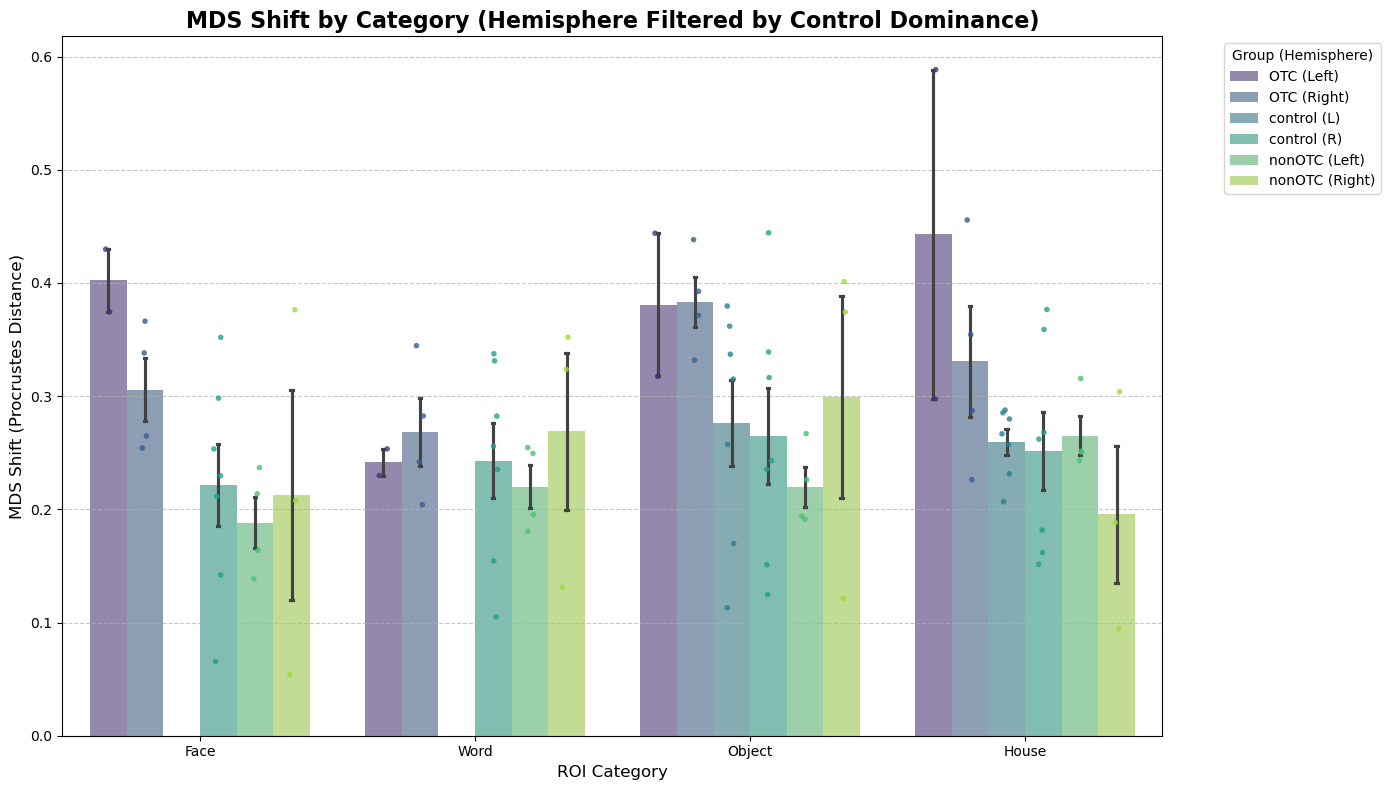


SUMMARY STATISTICS - HEMISPHERE FILTERED DATA

By Group and Category Type:
                           mean       std  count
Group   Category_Type                           
OTC     Bilateral      0.375425  0.096578     12
        Unilateral     0.298684  0.069762     12
control Bilateral      0.262985  0.084786     28
        Unilateral     0.232403  0.088460     14
nonOTC  Bilateral      0.244436  0.086458     14
        Unilateral     0.219850  0.088847     14

By Condition and Category:
                             mean       std  count
Condition      Category                           
OTC (Left)     Face      0.402193  0.039066      2
               House     0.443016  0.205731      2
               Object    0.380770  0.089434      2
               Word      0.241651  0.016638      2
OTC (Right)    Face      0.305840  0.054923      4
               House     0.330849  0.098283      4
               Object    0.383533  0.044322      4
               Word      0.268289  0.060129  

In [30]:
# =============================================================================
# CELL 5: PLOT MDS SHIFT WITH HEMISPHERE FILTERING
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("PLOTTING MDS SHIFT - HEMISPHERE FILTERED DATA")
print("="*80)

# Load the filtered MDS data from Cell 4
filtered_mds_csv = OUTPUT_DIR / 'mds_results_hemisphere_filtered_by_control_dominance.csv'

if not filtered_mds_csv.exists():
    print(f"⚠️  Filtered CSV not found: {filtered_mds_csv}")
    print("Please run Cell 4 first to create the filtered data")
else:
    # Load data
    df_plot = pd.read_csv(filtered_mds_csv)
    print(f"Loaded {len(df_plot)} rows for plotting")
    
    # Extract MDS values
    df_plot['MDS'] = df_plot['MDS_Shift']
    
    # Get hemisphere information
    def get_hemi(row):
        if row['Group'] == 'control':
            h = row['nonpt_hemi']  # 'R' or 'L'
        else:
            h = row['Intact_Hemisphere']  # 'left' or 'right'
        return h.lower().capitalize()  # Standardize to 'Left' or 'Right'
    
    df_plot['Hemisphere'] = df_plot.apply(get_hemi, axis=1)
    
    # Create condition labels
    df_plot['Condition'] = df_plot['Group'] + " (" + df_plot['Hemisphere'] + ")"
    
    # Apply exclusions
    exclusions = ['control025', 'control027', 'nonOTC045', 'nonOTC072']
    df_filtered = df_plot[~df_plot['Subject'].isin(exclusions)].copy()
    
    print(f"After exclusions: {len(df_filtered)} rows")
    print(f"\nConditions: {sorted(df_filtered['Condition'].unique())}")
    
    # Create plot
    plt.figure(figsize=(14, 8))
    
    # Define order
    category_order = ['Face', 'Word', 'Object', 'House']
    hue_order = sorted(df_filtered['Condition'].unique())
    
    # Bar plot with error bars
    ax = sns.barplot(
        data=df_filtered, 
        x="Category", 
        y="MDS", 
        hue="Condition",
        palette="viridis", 
        alpha=0.6, 
        errorbar="se",
        capsize=0.05,
        hue_order=hue_order,
        order=category_order
    )
    
    # Overlay individual data points
    sns.stripplot(
        data=df_filtered, 
        x="Category", 
        y="MDS", 
        hue="Condition",
        palette="viridis", 
        dodge=True, 
        ax=ax, 
        alpha=0.8, 
        jitter=True, 
        size=4, 
        legend=False, 
        hue_order=hue_order,
        order=category_order
    )
    
    # Formatting
    plt.title("MDS Shift by Category (Hemisphere Filtered by Control Dominance)", 
              fontsize=16, fontweight='bold')
    plt.ylabel("MDS Shift (Procrustes Distance)", fontsize=12)
    plt.xlabel("ROI Category", fontsize=12)
    plt.legend(title="Group (Hemisphere)", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save plot
    plot_output = OUTPUT_DIR / 'mds_shift_hemisphere_filtered.png'
    plt.savefig(plot_output, dpi=300, bbox_inches='tight')
    print(f"\n✓ Plot saved to: {plot_output}")
    
    plt.show()
    
    # Summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS - HEMISPHERE FILTERED DATA")
    print("="*80)
    
    # By Group and Category Type
    summary = df_filtered.groupby(['Group', 'Category_Type'])['MDS'].agg(['mean', 'std', 'count'])
    print("\nBy Group and Category Type:")
    print(summary)
    
    # By Condition and Category
    summary_cond = df_filtered.groupby(['Condition', 'Category'])['MDS'].agg(['mean', 'std', 'count'])
    print("\nBy Condition and Category:")
    print(summary_cond)
    
    print("\n" + "="*80)

In [66]:
# =============================================================================
# CELL 5B: COMPUTE SUM SELECTIVITY AND MEAN ACTIVATION (INDEPENDENT)
# =============================================================================

from nilearn import masking, image

THRESH = 2.3  # z-score threshold

def compute_sum_selectivity_and_activity(functional_results, cope_map, subjects_dict):
    """
    Compute sum selectivity and mean activation
    Uses category-specific cope at T1
    """
    
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]  # Already a string
        
        for roi_key, sessions_data in rois.items():
            if first_session not in sessions_data:
                continue
            
            hemi = roi_key.split('_')[0]
            category = roi_key.split('_')[1]
            cope_num, mult = cope_map[category]
            
            # Get z-stat file at T1
            feat_dir = BASE_DIR / sid / f'ses-{first_session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
            
            # Get ROI mask
            roi_file = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
            
            if not zstat_file.exists() or not roi_file.exists():
                continue
            
            try:
                # Load and threshold
                func = image.load_img(str(zstat_file))
                func_thresh = image.threshold_img(func, threshold=THRESH)
                
                # Apply mask
                mask = image.load_img(str(roi_file))
                vox_resp = masking.apply_mask(func_thresh, mask)
                vox_resp = vox_resp[vox_resp > 0]
                
                if len(vox_resp) > 0:
                    sum_selec = float(np.sum(vox_resp))
                    mean_act = float(np.mean(vox_resp))
                    n_voxels = len(vox_resp)
                else:
                    sum_selec = 0.0
                    mean_act = 0.0
                    n_voxels = 0
                
                results.append({
                    'subject': sid,
                    'code': info.get('code', sid),
                    'group': info.get('group', 'unknown'),
                    'hemi': hemi,
                    'category': category,
                    'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                    'sum_selectivity': sum_selec,
                    'mean_activation': mean_act,
                    'n_voxels': n_voxels
                })
                
            except Exception as e:
                print(f"Error {sid} {roi_key}: {e}")
                continue
    
    return pd.DataFrame(results)

print("="*80)
print("COMPUTING SUM SELECTIVITY AND MEAN ACTIVATION - ALL COPE MAPS")
print("="*80)

# Compute for all cope maps
for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
    print(f"\n{cope_info['name']}...")
    
    extractions = all_extractions[cope_key]
    selectivity_df = compute_sum_selectivity_and_activity(extractions, cope_info['map'], ANALYSIS_SUBJECTS)
    
    # Add to all_results
    all_results[cope_key]['sum_selectivity'] = selectivity_df
    all_results[cope_key]['mean_activation'] = selectivity_df  # Same df, different columns
    
    print(f"  ✓ {len(selectivity_df)} measurements")

print("\n✓ Sum selectivity and mean activation computed for all cope maps")

COMPUTING SUM SELECTIVITY AND MEAN ACTIVATION - ALL COPE MAPS

Liu Mixed (Face>Obj, Word>Scr, Obj>Scr, House>Obj)...
  ✓ 108 measurements

All vs Scramble...
  ✓ 108 measurements

Category vs All Others...
  ✓ 107 measurements

Current (Face>Scr, Word inverted, Obj>Scr, House>Scr)...
  ✓ 108 measurements

✓ Sum selectivity and mean activation computed for all cope maps


In [38]:
# =============================================================================
# CELL 2C: SUMMARY OF SUMMED SELECTIVITY - ALL SCHEMES
# =============================================================================

print("="*80)
print("SUMMED SELECTIVITY SUMMARY - ALL CONTRAST SCHEMES")
print("="*80)

for scheme_name, df in all_results.items():
    print(f"\n{'='*80}")
    print(f"{scheme_name.upper().replace('_', ' ')}")
    print(f"{'='*80}")
    
    # Filter valid data
    valid_data = df[df['sum_selectivity'].notna()].copy()
    
    # Summary by Group, Category, Hemisphere
    summary = valid_data.groupby(['group', 'category', 'hemisphere'])['sum_selectivity'].agg(['mean', 'std', 'count'])
    
    print("\nBy Group, Category, and Hemisphere:")
    print(summary)
    
    # Also show just controls for easy comparison
    print("\n" + "-"*80)
    print("CONTROLS ONLY (for dominance determination):")
    print("-"*80)
    controls = valid_data[valid_data['group'] == 'control']
    control_summary = controls.groupby(['category', 'hemisphere'])['sum_selectivity'].agg(['mean', 'std', 'count'])
    print(control_summary)
    
    # Pivot for easy hemisphere comparison
    print("\n" + "-"*80)
    print("CONTROLS - HEMISPHERE COMPARISON:")
    print("-"*80)
    pivot = controls.pivot_table(
        index='category',
        columns='hemisphere',
        values='sum_selectivity',
        aggfunc=['mean', 'std']
    )
    print(pivot)

# Create comprehensive comparison DataFrame
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON - ALL SCHEMES")
print("="*80)

all_summaries = []

for scheme_name, df in all_results.items():
    valid_data = df[df['sum_selectivity'].notna()].copy()
    
    for group in ['OTC', 'nonOTC', 'control']:
        group_data = valid_data[valid_data['group'] == group]
        
        for category in ['face', 'word', 'object', 'house']:
            cat_data = group_data[group_data['category'] == category]
            
            for hemisphere in ['left', 'right']:
                hemi_data = cat_data[cat_data['hemisphere'] == hemisphere]
                
                if len(hemi_data) > 0:
                    all_summaries.append({
                        'contrast_scheme': scheme_name,
                        'group': group,
                        'category': category,
                        'hemisphere': hemisphere,
                        'mean_sum_selectivity': hemi_data['sum_selectivity'].mean(),
                        'std_sum_selectivity': hemi_data['sum_selectivity'].std(),
                        'n_subjects': len(hemi_data)
                    })

comprehensive_df = pd.DataFrame(all_summaries)

# Save comprehensive summary
output_file = OUTPUT_DIR / 'summed_selectivity_comprehensive_summary.csv'
comprehensive_df.to_csv(output_file, index=False)
print(f"\n✓ Comprehensive summary saved to: {output_file}")

# Create a nice pivot table for controls
print("\n" + "="*80)
print("CONTROLS SUMMARY TABLE - ALL SCHEMES")
print("="*80)

controls_only = comprehensive_df[comprehensive_df['group'] == 'control']
controls_pivot = controls_only.pivot_table(
    index=['category', 'hemisphere'],
    columns='contrast_scheme',
    values='mean_sum_selectivity'
)
print(controls_pivot)

SUMMED SELECTIVITY SUMMARY - ALL CONTRAST SCHEMES

CATEGORY VS ALL

By Group, Category, and Hemisphere:
                                     mean           std  count
group   category hemisphere                                   
OTC     face     left        27032.955688  36895.369809      2
                 right       28779.438446  29146.026482      4
        house    left        20827.221680  15188.566653      2
                 right       17839.380322  14994.964787      4
        object   left        19264.891602   1233.808802      2
                 right       32914.941406  15935.939438      4
        word     left          138.961601    104.410279      2
                 right        2051.012966   2554.725212      4
control face     left        16312.995877   6204.868902      9
                 right       19916.981337   8776.223363      9
        house    left        39905.690104  19718.765530      9
                 right       39542.064562  18357.018018      9
        object

CREATING SUMMED SELECTIVITY VISUALIZATIONS
category_vs_all: 200 → 200 rows after exclusions
category_vs_scramble: 200 → 200 rows after exclusions
original_incorrect: 200 → 200 rows after exclusions

EXCLUSIONS APPLIED
Excluded subjects: control025, control027, nonOTC045, nonOTC072
✓ Plot 1 saved: summed_selectivity_controls_comparison_EXCLUDED.png


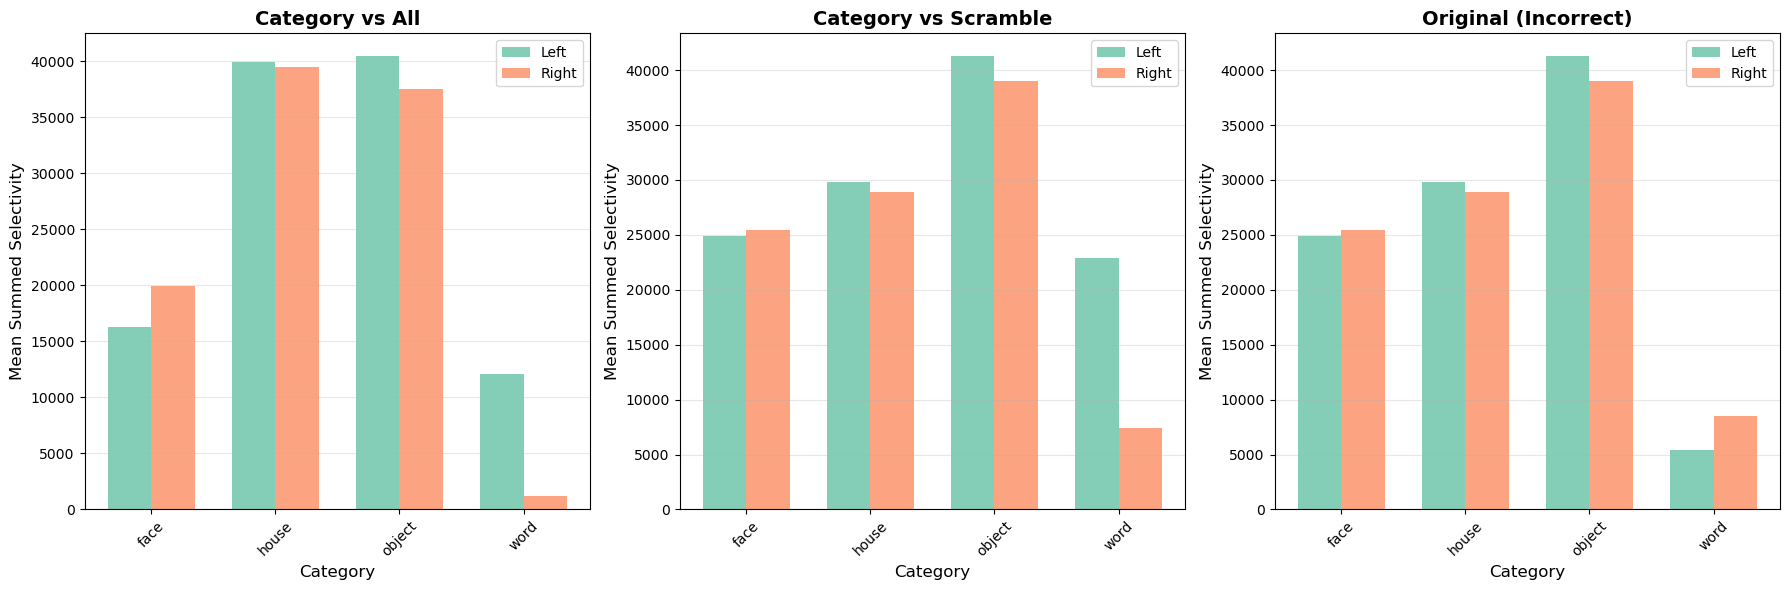

✓ Plot 2 saved: summed_selectivity_word_comparison_EXCLUDED.png


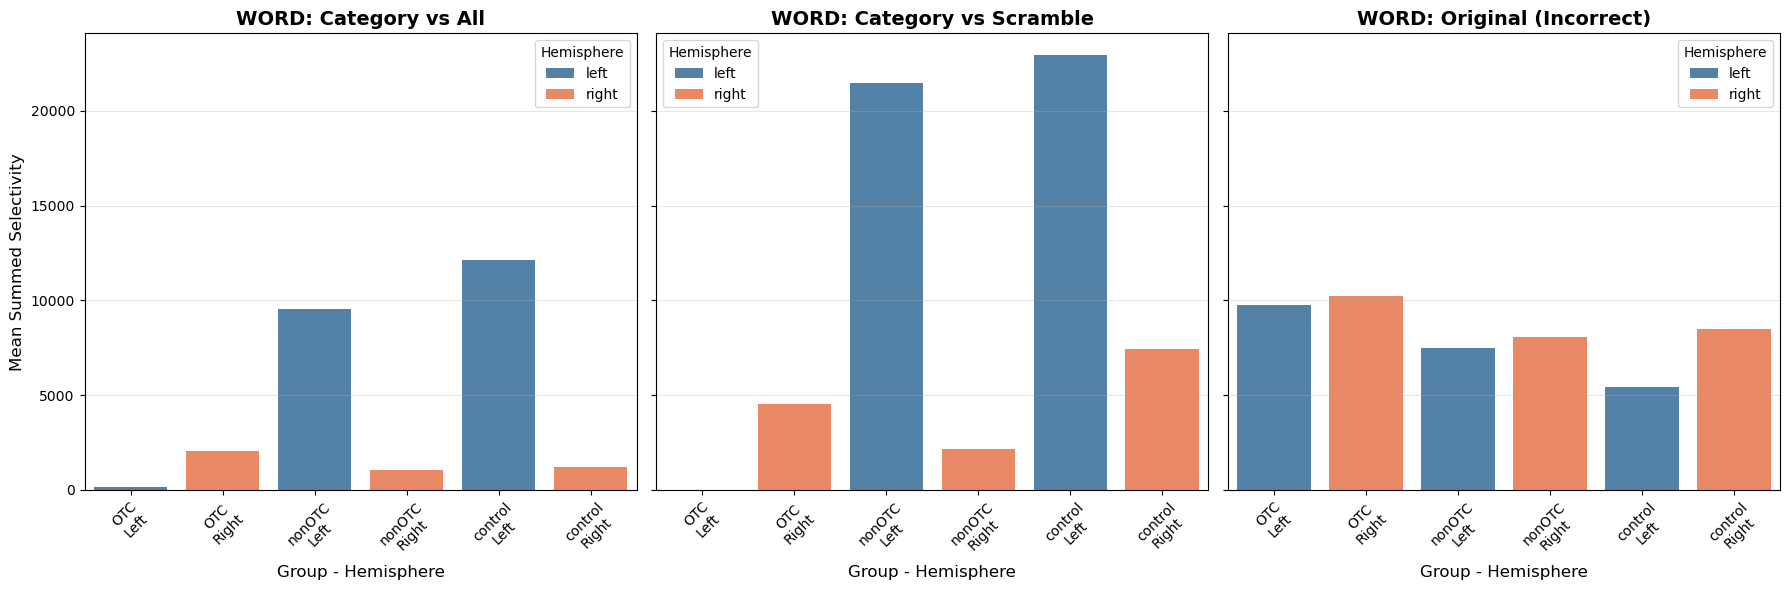

✓ Plot 3 saved: lateralization_index_comparison_EXCLUDED.png


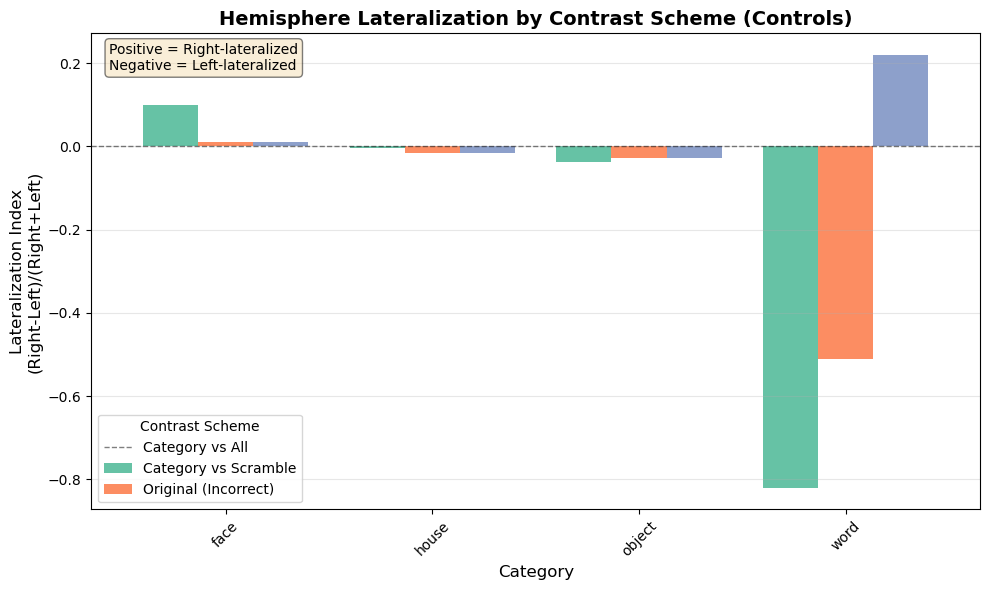

✓ Plot 4 saved: summed_selectivity_all_groups_category_vs_all_EXCLUDED.png


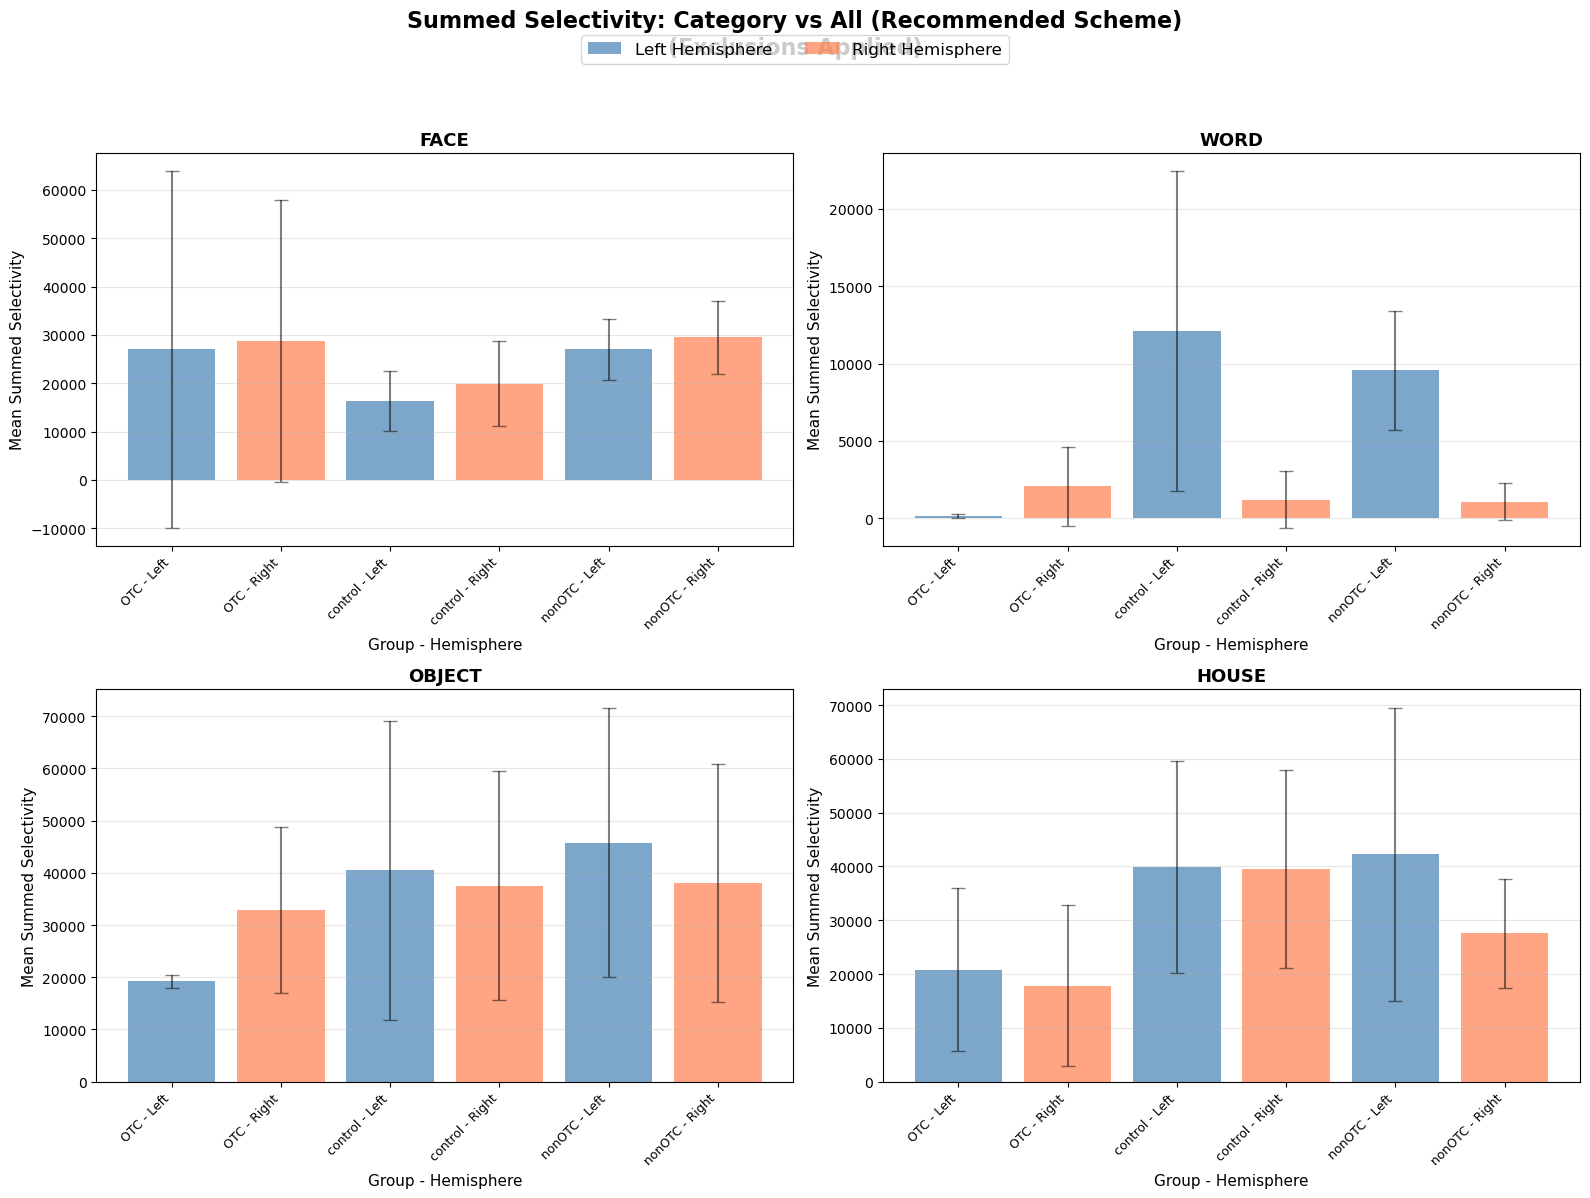


ALL PLOTS SAVED TO:
  /user_data/csimmon2/long_pt/hemisphere_dominance_analysis


In [40]:
# =============================================================================
# CELL 2D: VISUALIZE SUMMED SELECTIVITY ACROSS CONTRAST SCHEMES
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("CREATING SUMMED SELECTIVITY VISUALIZATIONS")
print("="*80)

# Set style
sns.set_palette("Set2")

# Load comprehensive data
comprehensive_df = pd.read_csv(OUTPUT_DIR / 'summed_selectivity_comprehensive_summary.csv')

# APPLY EXCLUSIONS
exclusions = ['control025', 'control027', 'nonOTC045', 'nonOTC072']

# Need to merge with subject info to get subject names
# The comprehensive_df has group/category/hemisphere but not individual subjects
# We need to go back to the original results and filter

# Filter all_results dictionaries
all_results_filtered = {}
for scheme_name, df in all_results.items():
    df_filtered = df[~df['subject'].isin(exclusions)].copy()
    all_results_filtered[scheme_name] = df_filtered
    print(f"{scheme_name}: {len(df)} → {len(df_filtered)} rows after exclusions")

# Recalculate comprehensive summary with exclusions
all_summaries_filtered = []

for scheme_name, df in all_results_filtered.items():
    valid_data = df[df['sum_selectivity'].notna()].copy()
    
    for group in ['OTC', 'nonOTC', 'control']:
        group_data = valid_data[valid_data['group'] == group]
        
        for category in ['face', 'word', 'object', 'house']:
            cat_data = group_data[group_data['category'] == category]
            
            for hemisphere in ['left', 'right']:
                hemi_data = cat_data[cat_data['hemisphere'] == hemisphere]
                
                if len(hemi_data) > 0:
                    all_summaries_filtered.append({
                        'contrast_scheme': scheme_name,
                        'group': group,
                        'category': category,
                        'hemisphere': hemisphere,
                        'mean_sum_selectivity': hemi_data['sum_selectivity'].mean(),
                        'std_sum_selectivity': hemi_data['sum_selectivity'].std(),
                        'n_subjects': len(hemi_data)
                    })

comprehensive_df_filtered = pd.DataFrame(all_summaries_filtered)

print("\n" + "="*80)
print("EXCLUSIONS APPLIED")
print("="*80)
print(f"Excluded subjects: {', '.join(exclusions)}")

# ============================================================================
# PLOT 1: Controls Hemisphere Comparison - All Schemes
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

schemes = ['category_vs_all', 'category_vs_scramble', 'original_incorrect']
scheme_titles = ['Category vs All', 'Category vs Scramble', 'Original (Incorrect)']

for idx, (scheme, title) in enumerate(zip(schemes, scheme_titles)):
    ax = axes[idx]
    
    # Filter to controls only for this scheme
    data = comprehensive_df_filtered[
        (comprehensive_df_filtered['contrast_scheme'] == scheme) & 
        (comprehensive_df_filtered['group'] == 'control')
    ]
    
    # Pivot for plotting
    pivot = data.pivot_table(
        index='category',
        columns='hemisphere',
        values='mean_sum_selectivity'
    )
    
    # Plot
    x = np.arange(len(pivot.index))
    width = 0.35
    
    ax.bar(x - width/2, pivot['left'], width, label='Left', alpha=0.8)
    ax.bar(x + width/2, pivot['right'], width, label='Right', alpha=0.8)
    
    ax.set_xlabel('Category', fontsize=12)
    ax.set_ylabel('Mean Summed Selectivity', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'summed_selectivity_controls_comparison_EXCLUDED.png', dpi=300, bbox_inches='tight')
print("✓ Plot 1 saved: summed_selectivity_controls_comparison_EXCLUDED.png")
plt.show()

# ============================================================================
# PLOT 2: Word Lateralization Across Schemes (All Groups)
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, (scheme, title) in enumerate(zip(schemes, scheme_titles)):
    ax = axes[idx]
    
    # Filter to word only
    data = comprehensive_df_filtered[comprehensive_df_filtered['contrast_scheme'] == scheme]
    word_data = data[data['category'] == 'word'].copy()
    
    # Create group-hemisphere labels
    word_data['group_hemi'] = word_data['group'] + '\n' + word_data['hemisphere'].str.capitalize()
    
    # Plot
    sns.barplot(
        data=word_data,
        x='group_hemi',
        y='mean_sum_selectivity',
        hue='hemisphere',
        ax=ax,
        palette=['steelblue', 'coral']
    )
    
    ax.set_xlabel('Group - Hemisphere', fontsize=12)
    ax.set_ylabel('Mean Summed Selectivity', fontsize=12)
    ax.set_title(f'WORD: {title}', fontsize=14, fontweight='bold')
    ax.legend(title='Hemisphere')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'summed_selectivity_word_comparison_EXCLUDED.png', dpi=300, bbox_inches='tight')
print("✓ Plot 2 saved: summed_selectivity_word_comparison_EXCLUDED.png")
plt.show()

# ============================================================================
# PLOT 3: Lateralization Index Comparison (Controls)
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

controls_data = comprehensive_df_filtered[comprehensive_df_filtered['group'] == 'control']

# Calculate lateralization index: (R - L) / (R + L)
lat_indices = []

for scheme in schemes:
    scheme_data = controls_data[controls_data['contrast_scheme'] == scheme]
    
    for category in ['face', 'word', 'object', 'house']:
        cat_data = scheme_data[scheme_data['category'] == category]
        
        left = cat_data[cat_data['hemisphere'] == 'left']['mean_sum_selectivity'].values[0]
        right = cat_data[cat_data['hemisphere'] == 'right']['mean_sum_selectivity'].values[0]
        
        lat_index = (right - left) / (right + left)
        
        lat_indices.append({
            'scheme': scheme,
            'category': category,
            'lateralization_index': lat_index
        })

lat_df = pd.DataFrame(lat_indices)
lat_pivot = lat_df.pivot(index='category', columns='scheme', values='lateralization_index')

# Plot
lat_pivot.plot(kind='bar', ax=ax, width=0.8)
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Lateralization Index\n(Right-Left)/(Right+Left)', fontsize=12)
ax.set_title('Hemisphere Lateralization by Contrast Scheme (Controls)', fontsize=14, fontweight='bold')
ax.legend(['Category vs All', 'Category vs Scramble', 'Original (Incorrect)'], title='Contrast Scheme')
ax.grid(axis='y', alpha=0.3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Add annotations
ax.text(0.02, 0.98, 'Positive = Right-lateralized\nNegative = Left-lateralized', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lateralization_index_comparison_EXCLUDED.png', dpi=300, bbox_inches='tight')
print("✓ Plot 3 saved: lateralization_index_comparison_EXCLUDED.png")
plt.show()

# ============================================================================
# PLOT 4: All Groups, All Categories - Category vs All (Recommended)
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Use only category_vs_all scheme
cat_vs_all = comprehensive_df_filtered[comprehensive_df_filtered['contrast_scheme'] == 'category_vs_all']

categories = ['face', 'word', 'object', 'house']

for idx, category in enumerate(categories):
    ax = axes[idx]
    
    cat_data = cat_vs_all[cat_vs_all['category'] == category].copy()
    cat_data['group_hemi'] = cat_data['group'] + ' - ' + cat_data['hemisphere'].str.capitalize()
    
    # Sort for consistent ordering
    cat_data = cat_data.sort_values(['group', 'hemisphere'])
    
    # Plot
    x = np.arange(len(cat_data))
    colors = ['steelblue' if h == 'left' else 'coral' for h in cat_data['hemisphere']]
    
    bars = ax.bar(x, cat_data['mean_sum_selectivity'], color=colors, alpha=0.7)
    ax.errorbar(x, cat_data['mean_sum_selectivity'], 
                yerr=cat_data['std_sum_selectivity'],
                fmt='none', color='black', capsize=5, alpha=0.5)
    
    ax.set_xlabel('Group - Hemisphere', fontsize=11)
    ax.set_ylabel('Mean Summed Selectivity', fontsize=11)
    ax.set_title(f'{category.upper()}', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(cat_data['group_hemi'], rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', alpha=0.7, label='Left Hemisphere'),
    Patch(facecolor='coral', alpha=0.7, label='Right Hemisphere')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=12, 
          bbox_to_anchor=(0.5, 0.98))

plt.suptitle('Summed Selectivity: Category vs All (Recommended Scheme)\n(Exclusions Applied)', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(OUTPUT_DIR / 'summed_selectivity_all_groups_category_vs_all_EXCLUDED.png', dpi=300, bbox_inches='tight')
print("✓ Plot 4 saved: summed_selectivity_all_groups_category_vs_all_EXCLUDED.png")
plt.show()

print("\n" + "="*80)
print("ALL PLOTS SAVED TO:")
print(f"  {OUTPUT_DIR}")
print("="*80)

CREATING VIOLIN PLOTS FOR SUMMED SELECTIVITY
✓ Violin plot saved: violin_summed_selectivity_comparison.png


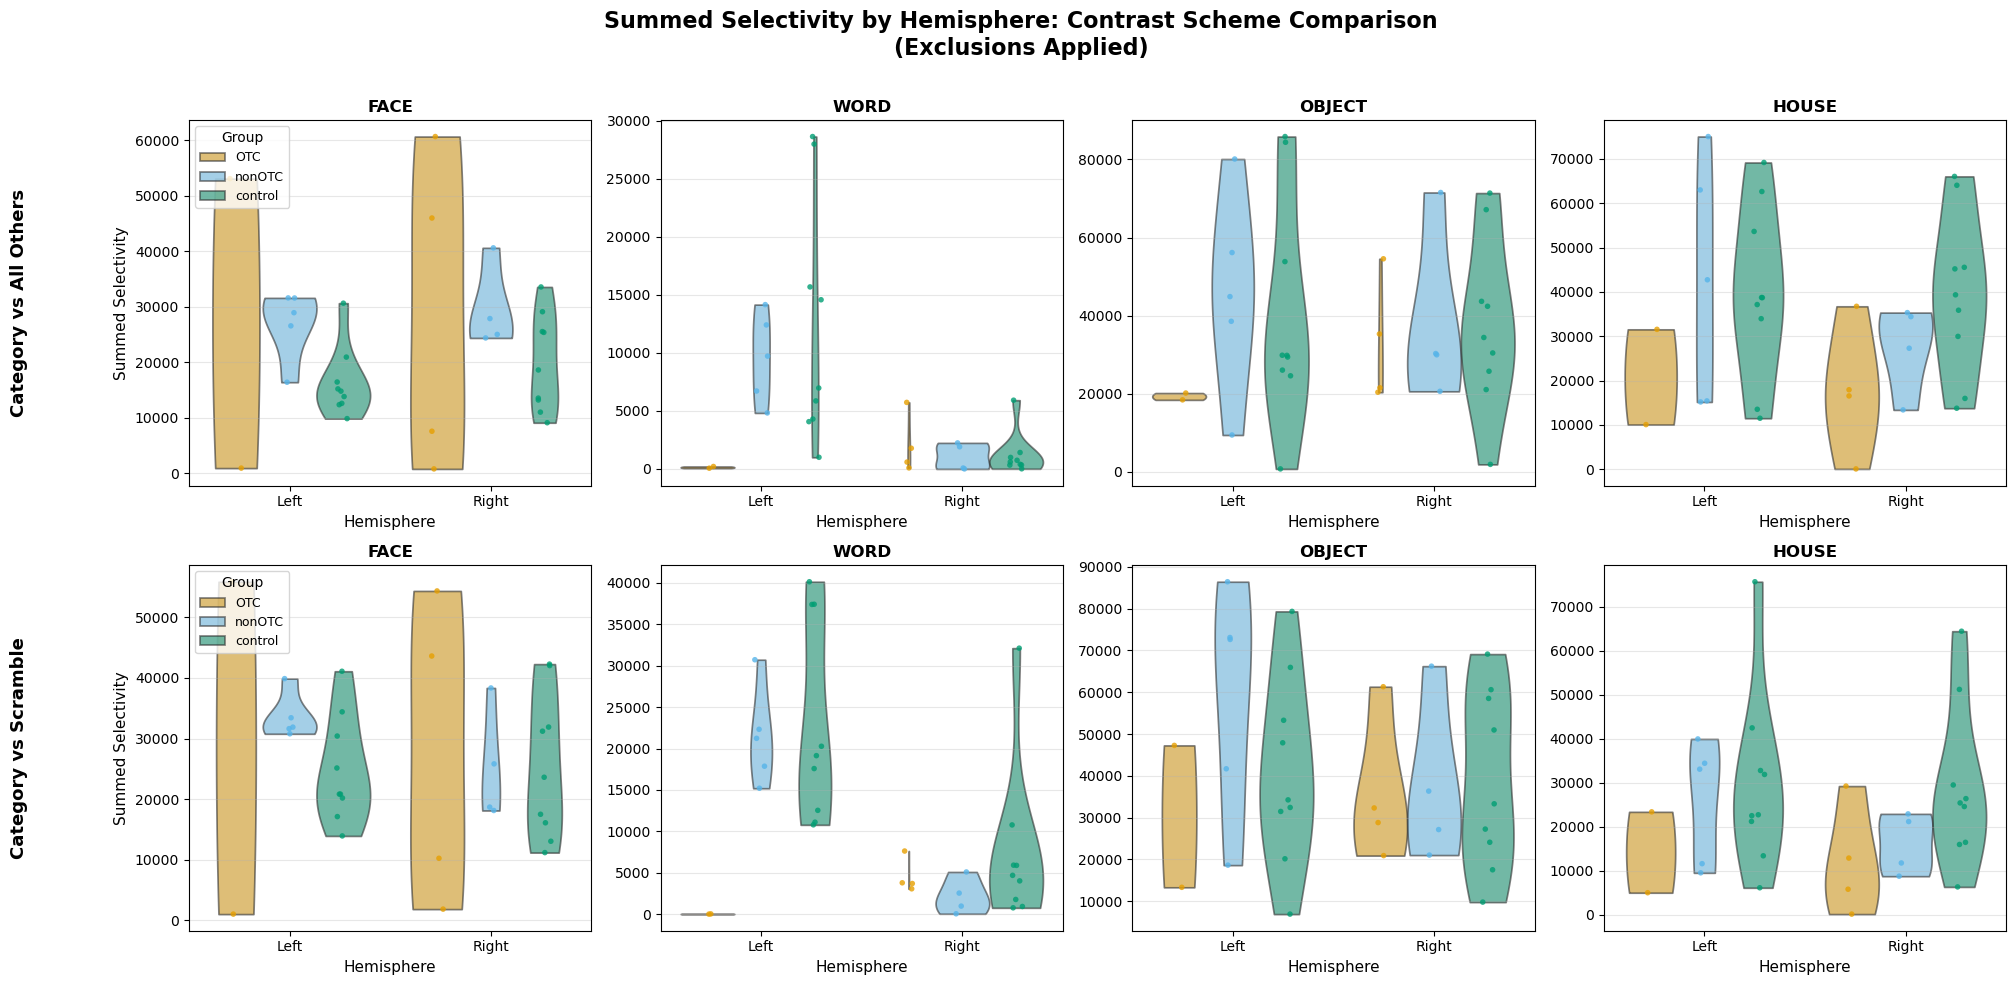

✓ Violin plot saved: violin_summed_selectivity_category_vs_all.png


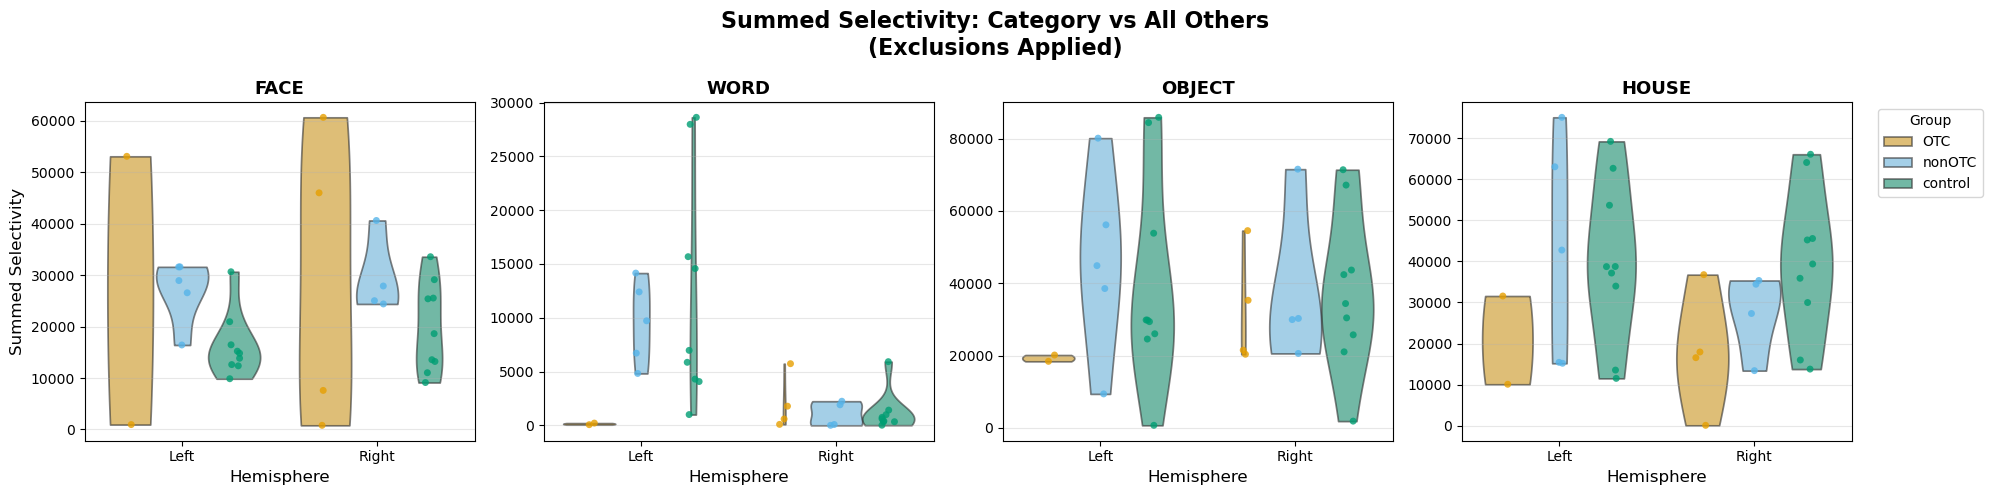

✓ Violin plot saved: violin_summed_selectivity_category_vs_scramble.png


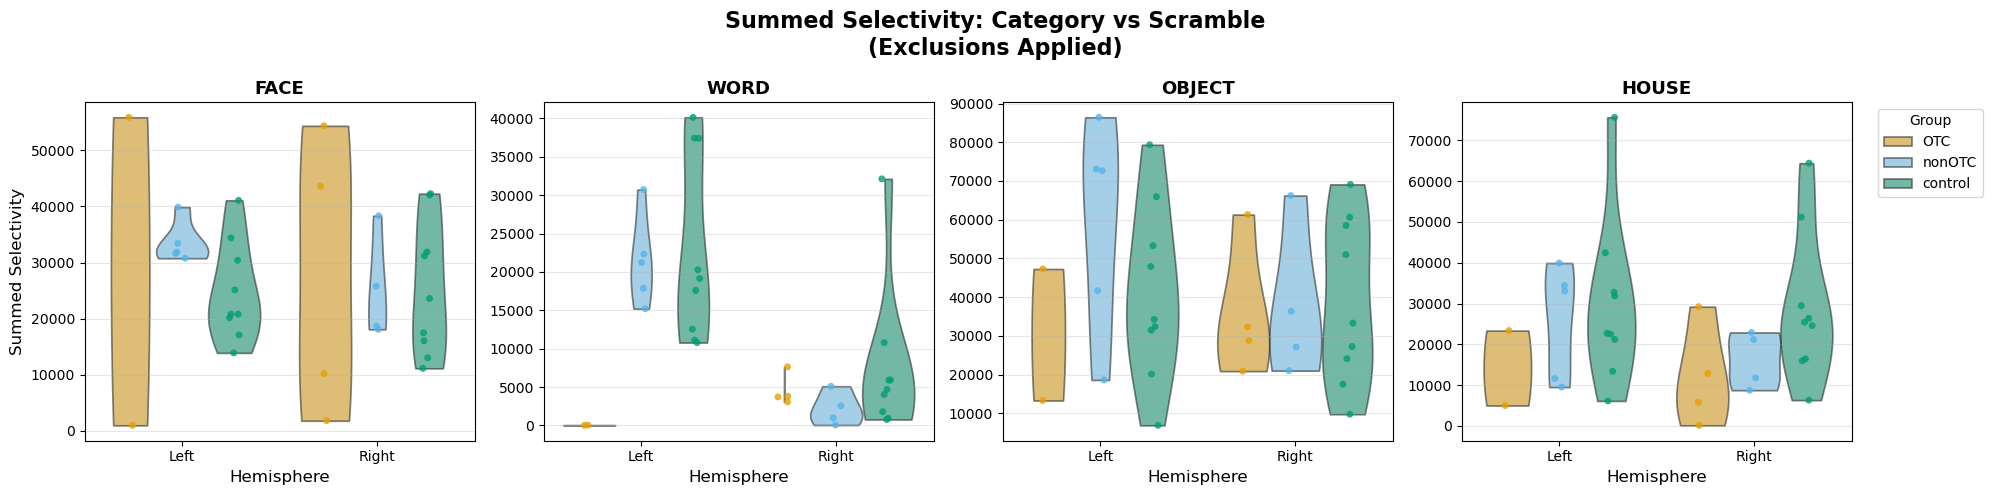


SUMMARY STATISTICS (WITH EXCLUSIONS)

CATEGORY VS ALL OTHERS
--------------------------------------------------------------------------------
                                     mean           std  count
group   category hemisphere                                   
OTC     face     left        27032.955688  36895.369809      2
                 right       28779.438446  29146.026482      4
        house    left        20827.221680  15188.566653      2
                 right       17839.380322  14994.964787      4
        object   left        19264.891602   1233.808802      2
                 right       32914.941406  15935.939438      4
        word     left          138.961601    104.410279      2
                 right        2051.012966   2554.725212      4
control face     left        16312.995877   6204.868902      9
                 right       19916.981337   8776.223363      9
        house    left        39905.690104  19718.765530      9
                 right       39542.064

In [41]:
# =============================================================================
# CELL 2E: VIOLIN PLOTS - CATEGORY VS ALL & CATEGORY VS SCRAMBLE
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("CREATING VIOLIN PLOTS FOR SUMMED SELECTIVITY")
print("="*80)

# Apply exclusions
exclusions = ['control025', 'control027', 'nonOTC045', 'nonOTC072']

# Get filtered data for the two schemes we want
schemes_to_plot = ['category_vs_all', 'category_vs_scramble']
scheme_labels = ['Category vs All Others', 'Category vs Scramble']

# Combine data from both schemes
plot_data = []

for scheme in schemes_to_plot:
    df = all_results[scheme].copy()
    # Apply exclusions
    df = df[~df['subject'].isin(exclusions)]
    # Keep only valid data
    df = df[df['sum_selectivity'].notna()]
    plot_data.append(df)

# ============================================================================
# PLOT: Violin plots for all categories - both schemes side by side
# ============================================================================

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

categories = ['face', 'word', 'object', 'house']
colors = {'OTC': '#E69F00', 'nonOTC': '#56B4E9', 'control': '#009E73'}

for scheme_idx, (scheme_name, scheme_label) in enumerate(zip(schemes_to_plot, scheme_labels)):
    df = plot_data[scheme_idx]
    
    for cat_idx, category in enumerate(categories):
        ax = axes[scheme_idx, cat_idx]
        
        # Filter to this category
        cat_data = df[df['category'] == category].copy()
        
        # Create hemisphere label for better display
        cat_data['hemi_label'] = cat_data['hemisphere'].str.capitalize()
        
        # Violin plot
        sns.violinplot(
            data=cat_data,
            x='hemi_label',
            y='sum_selectivity',
            hue='group',
            palette=colors,
            ax=ax,
            cut=0,
            inner=None,
            alpha=0.6
        )
        
        # Overlay individual points with stripplot
        sns.stripplot(
            data=cat_data,
            x='hemi_label',
            y='sum_selectivity',
            hue='group',
            palette=colors,
            ax=ax,
            dodge=True,
            size=4,
            alpha=0.8,
            legend=False
        )
        
        # Formatting
        ax.set_xlabel('Hemisphere', fontsize=11)
        ax.set_ylabel('Summed Selectivity' if cat_idx == 0 else '', fontsize=11)
        ax.set_title(f'{category.upper()}', fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Only show legend on first plot of each row
        if cat_idx == 0:
            ax.legend(title='Group', loc='upper left', fontsize=9)
        else:
            ax.get_legend().remove()
        
        # Add row label
        if cat_idx == 0:
            ax.text(-0.4, 0.5, scheme_label, 
                   transform=ax.transAxes, fontsize=13, fontweight='bold',
                   rotation=90, va='center', ha='right')

plt.suptitle('Summed Selectivity by Hemisphere: Contrast Scheme Comparison\n(Exclusions Applied)', 
            fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(OUTPUT_DIR / 'violin_summed_selectivity_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Violin plot saved: violin_summed_selectivity_comparison.png")
plt.show()

# ============================================================================
# PLOT: Separate figure for each scheme (larger, clearer)
# ============================================================================

for scheme_idx, (scheme_name, scheme_label) in enumerate(zip(schemes_to_plot, scheme_labels)):
    df = plot_data[scheme_idx]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for cat_idx, category in enumerate(categories):
        ax = axes[cat_idx]
        
        # Filter to this category
        cat_data = df[df['category'] == category].copy()
        cat_data['hemi_label'] = cat_data['hemisphere'].str.capitalize()
        
        # Violin plot
        sns.violinplot(
            data=cat_data,
            x='hemi_label',
            y='sum_selectivity',
            hue='group',
            palette=colors,
            ax=ax,
            cut=0,
            inner=None,
            alpha=0.6
        )
        
        # Overlay points
        sns.stripplot(
            data=cat_data,
            x='hemi_label',
            y='sum_selectivity',
            hue='group',
            palette=colors,
            ax=ax,
            dodge=True,
            size=5,
            alpha=0.8,
            legend=False
        )
        
        # Formatting
        ax.set_xlabel('Hemisphere', fontsize=12)
        ax.set_ylabel('Summed Selectivity' if cat_idx == 0 else '', fontsize=12)
        ax.set_title(f'{category.upper()}', fontsize=13, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Legend
        if cat_idx == 3:  # Put legend on last plot
            ax.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        else:
            ax.get_legend().remove()
    
    plt.suptitle(f'Summed Selectivity: {scheme_label}\n(Exclusions Applied)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = f'violin_summed_selectivity_{scheme_name}.png'
    plt.savefig(OUTPUT_DIR / filename, dpi=300, bbox_inches='tight')
    print(f"✓ Violin plot saved: {filename}")
    plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY STATISTICS (WITH EXCLUSIONS)")
print("="*80)

for scheme_name, scheme_label in zip(schemes_to_plot, scheme_labels):
    df = all_results[scheme_name].copy()
    df = df[~df['subject'].isin(exclusions)]
    df = df[df['sum_selectivity'].notna()]
    
    print(f"\n{scheme_label.upper()}")
    print("-" * 80)
    
    summary = df.groupby(['group', 'category', 'hemisphere'])['sum_selectivity'].agg(['mean', 'std', 'count'])
    print(summary)

print("\n" + "="*80)
print("ALL VIOLIN PLOTS SAVED TO:")
print(f"  {OUTPUT_DIR}")
print("="*80)

In [44]:
# =============================================================================
# CELL 2F: COMPARE THRESHOLDED vs UNTHRESHOLDED (FIXED)
# =============================================================================

print("="*80)
print("COMPARING THRESHOLDED vs UNTHRESHOLDED SUMMED SELECTIVITY")
print("="*80)

# Get a real subject from the data
test_sub = sub_info.iloc[0]['sub']  # Use first subject in CSV
first_ses = get_first_session(test_sub)
ses_str = f"{first_ses:02d}"

print(f"\nTesting with: {test_sub}, session {first_ses}")

for category in ['face', 'word']:
    print(f"\n{category.upper()}:")
    cope_num = 6 if category == 'face' else 9  # category_vs_all
    
    for hemisphere in ['left', 'right']:
        hemi_letter = hemisphere[0]
        
        # Paths
        zstat = BASE_DIR / test_sub / f'ses-{ses_str}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
        roi_file = BASE_DIR / test_sub / f'ses-{ses_str}' / 'ROIs' / f'{hemi_letter}_{category}_searchmask.nii.gz'
        
        print(f"  {hemisphere}:")
        print(f"    zstat exists: {zstat.exists()}")
        print(f"    ROI exists: {roi_file.exists()}")
        
        if zstat.exists() and roi_file.exists():
            func = image.load_img(str(zstat))
            mask = image.load_img(str(roi_file))
            
            # Thresholded (current method)
            func_thresh = image.threshold_img(func, threshold=2.3)
            vox_thresh = masking.apply_mask(func_thresh, mask)
            vox_thresh_pos = vox_thresh[vox_thresh > 0]
            
            # Unthresholded (all positive values)
            vox_all = masking.apply_mask(func, mask)
            vox_all_pos = vox_all[vox_all > 0]
            
            print(f"    Thresholded (z>2.3): sum={np.sum(vox_thresh_pos):.1f}, n={len(vox_thresh_pos)}")
            print(f"    Unthresholded (z>0):  sum={np.sum(vox_all_pos):.1f}, n={len(vox_all_pos)}")

COMPARING THRESHOLDED vs UNTHRESHOLDED SUMMED SELECTIVITY

Testing with: sub-004, session 1

FACE:
  left:
    zstat exists: True
    ROI exists: True
    Thresholded (z>2.3): sum=944.0, n=338
    Unthresholded (z>0):  sum=3923.5, n=3874
  right:
    zstat exists: True
    ROI exists: False

WORD:
  left:
    zstat exists: True
    ROI exists: True
    Thresholded (z>2.3): sum=65.1, n=26
    Unthresholded (z>0):  sum=2341.4, n=3372
  right:
    zstat exists: True
    ROI exists: False


In [46]:
#!/usr/bin/env python3
"""
Comprehensive COPE Map Comparison
Rerun all key analyses with different cope maps to test robustness of findings
"""

import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
from scipy.stats import ttest_ind, pearsonr
from scipy.ndimage import label, center_of_mass
from scipy.spatial.distance import squareform
from scipy.linalg import orthogonal_procrustes
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CELL 1: CONFIGURATION - Define All COPE Maps to Test
# =============================================================================

BASE_DIR = Path("/user_data/csimmon2/long_pt")
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
OUTPUT_DIR = BASE_DIR / "cope_map_comparison"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}
EXCLUDE_SUBS = ['sub-025', 'sub-027', 'sub-045', 'sub-072']

# Define all cope maps to test
COPE_MAPS_TO_TEST = {
    'liu_mixed': {
        'name': 'Liu Mixed (Face>Obj, Word>Scr, Obj>Scr, House>Obj)',
        'map': {'face': (1, 1), 'word': (12, 1), 'object': (3, 1), 'house': (2, 1)}
    },
    'all_scramble': {
        'name': 'All vs Scramble',
        'map': {'face': (10, 1), 'word': (12, 1), 'object': (3, 1), 'house': (11, 1)}
    },
    'all_vs_others': {
        'name': 'Category vs All Others',
        'map': {'face': (6, 1), 'word': (9, 1), 'object': (8, 1), 'house': (7, 1)}
    },
    'current_differential': {
        'name': 'Current (Face>Scr, Word inverted, Obj>Scr, House>Scr)',
        'map': {'face': (10, 1), 'word': (13, -1), 'object': (3, 1), 'house': (11, 1)}
    }
}

print("="*80)
print("COPE MAP COMPARISON FRAMEWORK")
print("="*80)
print(f"\nTesting {len(COPE_MAPS_TO_TEST)} different cope map schemes:")
for key, info in COPE_MAPS_TO_TEST.items():
    print(f"\n{key}:")
    print(f"  {info['name']}")
    for cat, (cope, mult) in info['map'].items():
        sign = '+' if mult > 0 else '-'
        print(f"    {cat}: cope{cope} {sign}{abs(mult)}")

# =============================================================================
# CELL 2: LOAD SUBJECTS
# =============================================================================

df = pd.read_csv(CSV_FILE)

def load_subjects():
    subjects = {}
    
    for _, row in df.iterrows():
        subject_id = row['sub']
        if subject_id in EXCLUDE_SUBS:
            continue
            
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
        
        sessions = sorted([d.name.replace('ses-', '') for d in subj_dir.glob('ses-*') if d.is_dir()], key=int)
        start_session = SESSION_START.get(subject_id, 1)
        sessions = [s for s in sessions if int(s) >= start_session]
        
        if not sessions:
            continue
        
        hemisphere = 'l' if str(row.get('intact_hemi', 'left')).lower() == 'left' else 'r'
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control'
        }
    
    return subjects

ANALYSIS_SUBJECTS = load_subjects()
print(f"\n✓ Loaded {len(ANALYSIS_SUBJECTS)} subjects (exclusions applied)")

# =============================================================================
# CELL 3: HELPER FUNCTIONS
# =============================================================================

def get_first_session(sub):
    return SESSION_START.get(sub, 1)

def create_sphere(center_coord, affine, brain_shape, radius=6):
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]),
        np.arange(brain_shape[1]),
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - center_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

def mds_2d(rdm):
    """Classical MDS to 2D"""
    n = rdm.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * H @ (rdm ** 2) @ H
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    coords = eigvecs[:, :2] * np.sqrt(np.maximum(eigvals[:2], 0))
    return coords

print("✓ Helper functions loaded")

# =============================================================================
# CELL 4: EXTRACT TOP 20% ROIs (All Cope Maps)
# =============================================================================

def extract_top20_rois(subject_id, cope_map, subjects_dict, percentile=80, min_cluster_size=20):
    """Extract ROIs using top 20% threshold"""
    
    info = subjects_dict[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists():
        return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, (cope_num, multiplier) in cope_map.items():
            
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists():
                continue
            
            try:
                search_mask_img = nib.load(mask_file)
                search_mask = search_mask_img.get_fdata() > 0
                affine = search_mask_img.affine
            except:
                continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists():
                    continue
                
                try:
                    z_full = nib.load(cope_file).get_fdata() * multiplier
                    pos_voxels = z_full[search_mask & (z_full > 0)]
                    
                    if len(pos_voxels) < min_cluster_size:
                        continue
                    
                    dynamic_thresh = max(np.percentile(pos_voxels, percentile), 1.64)
                    suprathresh = (z_full > dynamic_thresh) & search_mask
                    labeled, n_clusters = label(suprathresh)
                    
                    if n_clusters == 0:
                        continue
                    
                    best_idx, max_size = -1, 0
                    for i in range(1, n_clusters + 1):
                        size = np.sum(labeled == i)
                        if size > max_size:
                            max_size = size
                            best_idx = i
                    
                    if best_idx == -1 or max_size < min_cluster_size:
                        continue
                    
                    roi_mask = (labeled == best_idx)
                    peak_idx = np.unravel_index(np.argmax(z_full * roi_mask), z_full.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': float(z_full[peak_idx]),
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'threshold': dynamic_thresh
                    }
                except Exception as e:
                    continue
                    
    return all_results

print("\n" + "="*80)
print("EXTRACTING ROIs FOR ALL COPE MAPS")
print("="*80)

all_extractions = {}

for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
    print(f"\nExtracting: {cope_info['name']}...")
    
    extractions = {}
    for sub in ANALYSIS_SUBJECTS:
        res = extract_top20_rois(sub, cope_info['map'], ANALYSIS_SUBJECTS)
        if res:
            extractions[sub] = res
    
    all_extractions[cope_key] = extractions
    print(f"  ✓ {len(extractions)} subjects")

print("\n✓ All ROI extractions complete")

# =============================================================================
# CELL 5: COMPUTE ALL MEASURES FOR EACH COPE MAP
# =============================================================================

def compute_spatial_relocation(functional_results, subjects_dict):
    """Spatial drift between T1 and T2 centroids"""
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            c1 = sessions_data[sessions[0]]['centroid']
            c2 = sessions_data[sessions[-1]]['centroid']
            drift = np.linalg.norm(np.array(c2) - np.array(c1))
            
            hemi = roi_key.split('_')[0]
            category = roi_key.split('_')[1]
            
            results.append({
                'subject': sid,
                'code': info.get('code', sid),
                'group': info.get('group', 'unknown'),
                'hemi': hemi,
                'category': category,
                'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                'spatial_relocation': drift
            })
    
    return pd.DataFrame(results)

def compute_geometry_preservation(functional_results, cope_map, subjects_dict, radius=6):
    """RDM stability - correlation of RDMs between T1 and T2"""
    results = []
    categories = ['face', 'word', 'object', 'house']
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        # Get reference image
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in categories:
            for h in ['l', 'r']:
                test_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                if test_file.exists():
                    ref_file = test_file
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            hemi = roi_key.split('_')[0]
            roi_category = roi_key.split('_')[1]
            
            # Spheres at each session's centroid
            sphere_t1 = create_sphere(sessions_data[first_ses]['centroid'], affine, brain_shape, radius)
            sphere_t2 = create_sphere(sessions_data[last_ses]['centroid'], affine, brain_shape, radius)
            
            # Build RDMs
            rdms = {}
            for ses, sphere in [(first_ses, sphere_t1), (last_ses, sphere_t2)]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid = True
                
                for cat in categories:
                    cope_num, mult = cope_map[cat]
                    z_name = 'zstat1.nii.gz' if ses == first_session else f'zstat1_ses{first_session}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        valid = False
                        break
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        valid = False
                        break
                    
                    patterns.append(pattern)
                
                if not valid or len(patterns) != 4:
                    continue
                
                try:
                    corr_matrix = np.corrcoef(patterns)
                    rdm = 1 - corr_matrix
                    rdms[ses] = rdm
                except:
                    continue
            
            if len(rdms) == 2:
                try:
                    triu_idx = np.triu_indices(4, k=1)
                    r, _ = pearsonr(rdms[first_ses][triu_idx], rdms[last_ses][triu_idx])
                    
                    results.append({
                        'subject': sid,
                        'code': info.get('code', sid),
                        'group': info.get('group', 'unknown'),
                        'hemi': hemi,
                        'category': roi_category,
                        'category_type': 'Bilateral' if roi_category in ['object', 'house'] else 'Unilateral',
                        'geometry_preservation': r
                    })
                except:
                    continue
    
    return pd.DataFrame(results)

def compute_anchored_stability(functional_results, cope_map, subjects_dict, radius=6):
    """Pattern correlation at fixed T1 location"""
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        # Get reference image
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in ['face', 'object', 'house', 'word']:
            for h in ['l', 'r']:
                test_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                if test_file.exists():
                    ref_file = test_file
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            
            # ANCHORED: sphere at T1 centroid only
            sphere = create_sphere(sessions_data[first_ses]['centroid'], affine, brain_shape, radius)
            
            category = roi_key.split('_')[1]
            cope_num, mult = cope_map[category]
            
            patterns = {}
            for ses in [first_ses, last_ses]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if ses == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists():
                    continue
                
                data = nib.load(cope_file).get_fdata() * mult
                pattern = data[sphere]
                
                if len(pattern) > 0 and np.all(np.isfinite(pattern)):
                    patterns[ses] = pattern
            
            if len(patterns) == 2:
                try:
                    r, _ = pearsonr(patterns[first_ses], patterns[last_ses])
                    
                    hemi = roi_key.split('_')[0]
                    
                    results.append({
                        'subject': sid,
                        'code': info.get('code', sid),
                        'group': info.get('group', 'unknown'),
                        'hemi': hemi,
                        'category': category,
                        'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                        'anchored_stability': r
                    })
                except:
                    continue
    
    return pd.DataFrame(results)

def compute_liu_distinctiveness(functional_results, cope_map, subjects_dict, radius=6):
    """Liu Distinctiveness - preferred vs non-preferred correlation"""
    results = []
    categories = ['face', 'word', 'object', 'house']
    roi_preferred = {'face': 'face', 'word': 'word', 'object': 'object', 'house': 'house'}
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        # Get reference image
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in categories:
            for h in ['l', 'r']:
                test_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                if test_file.exists():
                    ref_file = test_file
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            hemi = roi_key.split('_')[0]
            roi_category = roi_key.split('_')[1]
            
            preferred_cat = roi_preferred[roi_category]
            
            # Get distinctiveness at T1 and T2
            liu_values = {}
            
            for ses in [first_ses, last_ses]:
                # Sphere at this session's centroid
                sphere = create_sphere(sessions_data[ses]['centroid'], affine, brain_shape, radius)
                
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid_cats = []
                
                for cat in categories:
                    cope_num, mult = cope_map[cat]
                    
                    # USE COPE (BETA) FILES FOR LIU DISTINCTIVENESS!
                    if ses == first_session:
                        cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
                    else:
                        cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / f'cope1_ses{first_session}.nii.gz'
                    
                    if not cope_file.exists():
                        continue
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        continue
                    
                    patterns.append(pattern)
                    valid_cats.append(cat)
                
                if len(patterns) != 4 or preferred_cat not in valid_cats:
                    continue
                
                try:
                    # Match voxel counts
                    min_voxels = min(len(p) for p in patterns)
                    patterns = [p[:min_voxels] for p in patterns]
                    
                    # Correlation matrix with Fisher transform
                    corr_matrix = np.corrcoef(patterns)
                    corr_fisher = np.arctanh(np.clip(corr_matrix, -0.999, 0.999))
                    
                    # Get preferred category index
                    pref_idx = valid_cats.index(preferred_cat)
                    nonpref_indices = [i for i, cat in enumerate(valid_cats) if cat != preferred_cat]
                    
                    # Liu distinctiveness = mean correlation preferred vs non-preferred
                    pref_vs_nonpref = corr_fisher[pref_idx, nonpref_indices]
                    liu_values[ses] = np.mean(pref_vs_nonpref)
                    
                except:
                    continue
            
            if len(liu_values) == 2:
                # Change in distinctiveness
                change = abs(liu_values[last_ses] - liu_values[first_ses])
                
                results.append({
                    'subject': sid,
                    'code': info.get('code', sid),
                    'group': info.get('group', 'unknown'),
                    'hemi': hemi,
                    'category': roi_category,
                    'category_type': 'Bilateral' if roi_category in ['object', 'house'] else 'Unilateral',
                    'liu_distinctiveness': change
                })
    
    return pd.DataFrame(results)

def compute_mds_shift(functional_results, cope_map, subjects_dict, radius=6):
    """MDS Procrustes distance"""
    results = []
    categories = ['face', 'word', 'object', 'house']
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        # Get reference image
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in categories:
            for h in ['l', 'r']:
                test_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                if test_file.exists():
                    ref_file = test_file
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            hemi = roi_key.split('_')[0]
            roi_category = roi_key.split('_')[1]
            
            # Spheres at each session's centroid
            sphere_t1 = create_sphere(sessions_data[first_ses]['centroid'], affine, brain_shape, radius)
            sphere_t2 = create_sphere(sessions_data[last_ses]['centroid'], affine, brain_shape, radius)
            
            # Build RDMs
            rdms = {}
            for ses, sphere in [(first_ses, sphere_t1), (last_ses, sphere_t2)]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid = True
                
                for cat in categories:
                    cope_num, mult = cope_map[cat]
                    z_name = 'zstat1.nii.gz' if ses == first_session else f'zstat1_ses{first_session}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        valid = False
                        break
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        valid = False
                        break
                    
                    patterns.append(pattern)
                
                if not valid or len(patterns) != 4:
                    continue
                
                try:
                    corr_matrix = np.corrcoef(patterns)
                    rdm = 1 - corr_matrix
                    rdms[ses] = rdm
                except:
                    continue
            
            if len(rdms) != 2:
                continue
            
            try:
                # MDS embedding
                coords_t1 = mds_2d(rdms[first_ses])
                coords_t2 = mds_2d(rdms[last_ses])
                
                # Procrustes align T1 to T2
                R, scale = orthogonal_procrustes(coords_t1, coords_t2)
                coords_t1_aligned = coords_t1 @ R
                
                # Euclidean distance each category moved
                for i, cat in enumerate(categories):
                    dist = np.linalg.norm(coords_t1_aligned[i] - coords_t2[i])
                    
                    results.append({
                        'subject': sid,
                        'code': info.get('code', sid),
                        'group': info.get('group', 'unknown'),
                        'hemi': hemi,
                        'roi_category': roi_category,
                        'measured_category': cat,
                        'category_type': 'Bilateral' if cat in ['object', 'house'] else 'Unilateral',
                        'mds_shift': dist
                    })
                    
            except Exception as e:
                continue
    
    return pd.DataFrame(results)

print("\n" + "="*80)
print("COMPUTING ALL MEASURES FOR EACH COPE MAP")
print("="*80)

all_results = {}

for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
    print(f"\n{cope_info['name']}:")
    print("-"*80)
    
    extractions = all_extractions[cope_key]
    
    # Compute all measures
    print("  Computing Liu Distinctiveness...", end=" ")
    liu = compute_liu_distinctiveness(extractions, cope_info['map'], ANALYSIS_SUBJECTS, radius=6)
    print(f"{len(liu)} measurements")
    
    print("  Computing Spatial Relocation...", end=" ")
    spatial = compute_spatial_relocation(extractions, ANALYSIS_SUBJECTS)
    print(f"{len(spatial)} measurements")
    
    print("  Computing Geometry Preservation...", end=" ")
    geometry = compute_geometry_preservation(extractions, cope_info['map'], ANALYSIS_SUBJECTS, radius=6)
    print(f"{len(geometry)} measurements")
    
    print("  Computing Anchored Stability...", end=" ")
    anchored = compute_anchored_stability(extractions, cope_info['map'], ANALYSIS_SUBJECTS, radius=6)
    print(f"{len(anchored)} measurements")
    
    print("  Computing MDS Shift...", end=" ")
    mds = compute_mds_shift(extractions, cope_info['map'], ANALYSIS_SUBJECTS, radius=6)
    # Filter to matched categories only
    mds_matched = mds[mds['roi_category'] == mds['measured_category']].copy()
    print(f"{len(mds_matched)} measurements")
    
    all_results[cope_key] = {
        'liu': liu,
        'spatial': spatial,
        'geometry': geometry,
        'anchored': anchored,
        'mds': mds_matched
    }

print("\n✓ All measures computed for all cope maps")

# =============================================================================
# CELL 6: ANALYZE KEY FINDING - Bilateral > Unilateral in OTC
# =============================================================================

print("\n" + "="*80)
print("KEY FINDING: BILATERAL > UNILATERAL IN OTC")
print("="*80)
print("\n*** LIU DISTINCTIVENESS (MOST IMPORTANT) ***")
print("-"*80)

# Show Liu distinctiveness in detail first
for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
    df_liu = all_results[cope_key]['liu']
    
    otc = df_liu[df_liu['group'] == 'OTC']
    bil = otc[otc['category_type'] == 'Bilateral']['liu_distinctiveness']
    uni = otc[otc['category_type'] == 'Unilateral']['liu_distinctiveness']
    
    if len(bil) > 1 and len(uni) > 1:
        t_stat, p_val = ttest_ind(bil, uni)
        diff = bil.mean() - uni.mean()
        supports = (diff > 0 and p_val < 0.05)
        status = "✓✓ SUPPORTS" if supports else "✗ NO"
        
        print(f"\n{cope_info['name']}:")
        print(f"  Bilateral:  {bil.mean():.3f} ± {bil.std():.3f} (n={len(bil)})")
        print(f"  Unilateral: {uni.mean():.3f} ± {uni.std():.3f} (n={len(uni)})")
        print(f"  Difference: {diff:+.3f}, t={t_stat:.2f}, p={p_val:.4f} {status}")

print("\n" + "-"*80)
print("ALL OTHER MEASURES:")
print("-"*80)

comparison_results = []

measures_to_test = [
    ('liu', 'liu_distinctiveness', 'Liu Distinctiveness', True),  # MOST IMPORTANT
    ('mds', 'mds_shift', 'MDS Shift', True),
    ('geometry', 'geometry_preservation', 'Geometry Preservation', False),
    ('spatial', 'spatial_relocation', 'Spatial Relocation', True),
    ('anchored', 'anchored_stability', 'Anchored Stability', False)
]

for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
    print(f"\n{cope_info['name']}")
    print("-"*80)
    
    for measure_key, column_name, measure_name, higher_is_change in measures_to_test:
        df_measure = all_results[cope_key][measure_key]
        
        # OTC bilateral vs unilateral
        otc = df_measure[df_measure['group'] == 'OTC']
        bil = otc[otc['category_type'] == 'Bilateral'][column_name]
        uni = otc[otc['category_type'] == 'Unilateral'][column_name]
        
        if len(bil) > 1 and len(uni) > 1:
            t_stat, p_val = ttest_ind(bil, uni)
            diff = bil.mean() - uni.mean()
            
            # Check if supports hypothesis
            if higher_is_change:
                supports = (diff > 0 and p_val < 0.05)
            else:
                supports = (diff < 0 and p_val < 0.05)
            
            status = "✓✓" if supports else "✗"
            
            print(f"  {measure_name:25s}: Bil={bil.mean():.3f}, Uni={uni.mean():.3f}, "
                  f"Diff={diff:+.3f}, p={p_val:.4f} {status}")
            
            comparison_results.append({
                'cope_map': cope_key,
                'cope_name': cope_info['name'],
                'measure': measure_name,
                'bilateral_mean': bil.mean(),
                'unilateral_mean': uni.mean(),
                'difference': diff,
                'p_value': p_val,
                'supports_hypothesis': supports,
                'n_bilateral': len(bil),
                'n_unilateral': len(uni)
            })

# Save comparison table
comparison_df = pd.DataFrame(comparison_results)
output_file = OUTPUT_DIR / 'cope_map_comparison_summary.csv'
comparison_df.to_csv(output_file, index=False)
print(f"\n✓ Comparison summary saved to: {output_file}")

# =============================================================================
# CELL 7: SUMMARY TABLE - Which COPE Maps Preserve Key Findings
# =============================================================================

print("\n" + "="*80)
print("SUMMARY: WHICH COPE MAPS PRESERVE KEY FINDINGS?")
print("="*80)

# Pivot table showing which measures support hypothesis for each cope map
pivot = comparison_df.pivot_table(
    index='cope_map',
    columns='measure',
    values='supports_hypothesis',
    aggfunc='first'
)

print("\n✓ = Supports hypothesis (bilateral > unilateral in OTC, p < 0.05)")
print("✗ = Does not support\n")
print(pivot.replace({True: '✓', False: '✗'}))

# Count how many measures support hypothesis for each cope map
support_counts = comparison_df.groupby('cope_map')['supports_hypothesis'].sum()

# Check if Liu distinctiveness specifically is supported
liu_support = comparison_df[comparison_df['measure'] == 'Liu Distinctiveness'].set_index('cope_map')['supports_hypothesis']

print("\n" + "="*80)
print("COPE MAP RANKINGS (by # of measures supporting hypothesis)")
print("="*80)
print("\nNote: ★ = Liu Distinctiveness supported (MOST CRITICAL)\n")

for cope_key in support_counts.sort_values(ascending=False).index:
    count = support_counts[cope_key]
    name = COPE_MAPS_TO_TEST[cope_key]['name']
    liu_star = " ★" if liu_support.get(cope_key, False) else ""
    print(f"  {count}/5: {name}{liu_star}")

print("\n" + "="*80)
print("RECOMMENDED COPE MAP:")
# Prioritize Liu distinctiveness support
liu_supported_maps = liu_support[liu_support == True].index.tolist()
if liu_supported_maps:
    # Among Liu-supporting maps, pick one with most total support
    best_cope = max(liu_supported_maps, key=lambda x: support_counts[x])
    print(f"  {COPE_MAPS_TO_TEST[best_cope]['name']}")
    print(f"  Supports {support_counts[best_cope]}/5 measures (including Liu ★)")
else:
    best_cope = support_counts.idxmax()
    print(f"  {COPE_MAPS_TO_TEST[best_cope]['name']}")
    print(f"  Supports {support_counts[best_cope]}/5 measures")
    print(f"  ⚠️  WARNING: Does NOT support Liu Distinctiveness!")
print("="*80)

COPE MAP COMPARISON FRAMEWORK

Testing 4 different cope map schemes:

liu_mixed:
  Liu Mixed (Face>Obj, Word>Scr, Obj>Scr, House>Obj)
    face: cope1 +1
    word: cope12 +1
    object: cope3 +1
    house: cope2 +1

all_scramble:
  All vs Scramble
    face: cope10 +1
    word: cope12 +1
    object: cope3 +1
    house: cope11 +1

all_vs_others:
  Category vs All Others
    face: cope6 +1
    word: cope9 +1
    object: cope8 +1
    house: cope7 +1

current_differential:
  Current (Face>Scr, Word inverted, Obj>Scr, House>Scr)
    face: cope10 +1
    word: cope13 -1
    object: cope3 +1
    house: cope11 +1

✓ Loaded 21 subjects (exclusions applied)
✓ Helper functions loaded

EXTRACTING ROIs FOR ALL COPE MAPS

Extracting: Liu Mixed (Face>Obj, Word>Scr, Obj>Scr, House>Obj)...
  ✓ 20 subjects

Extracting: All vs Scramble...
  ✓ 20 subjects

Extracting: Category vs All Others...
  ✓ 20 subjects

Extracting: Current (Face>Scr, Word inverted, Obj>Scr, House>Scr)...
  ✓ 20 subjects

✓ All ROI ext


COMPREHENSIVE TREND COMPARISON - ALL CATEGORIES

Liu Mixed (Face>Obj, Word>Scr, Obj>Scr, House>Obj)

Liu Distinctiveness:
--------------------------------------------------------------------------------

Category               OTC          nonOTC         Control
-------------------------------------------------------
Face                 0.183           0.078           0.118
Word                 0.138           0.189           0.194
Object               0.359           0.150           0.272
House                0.240           0.195           0.454

Type                     OTC          nonOTC         Control
-------------------------------------------------------
Bilateral              0.300           0.173           0.363
Unilateral             0.161           0.134           0.156

MDS Shift:
--------------------------------------------------------------------------------

Category               OTC          nonOTC         Control
---------------------------------------------------

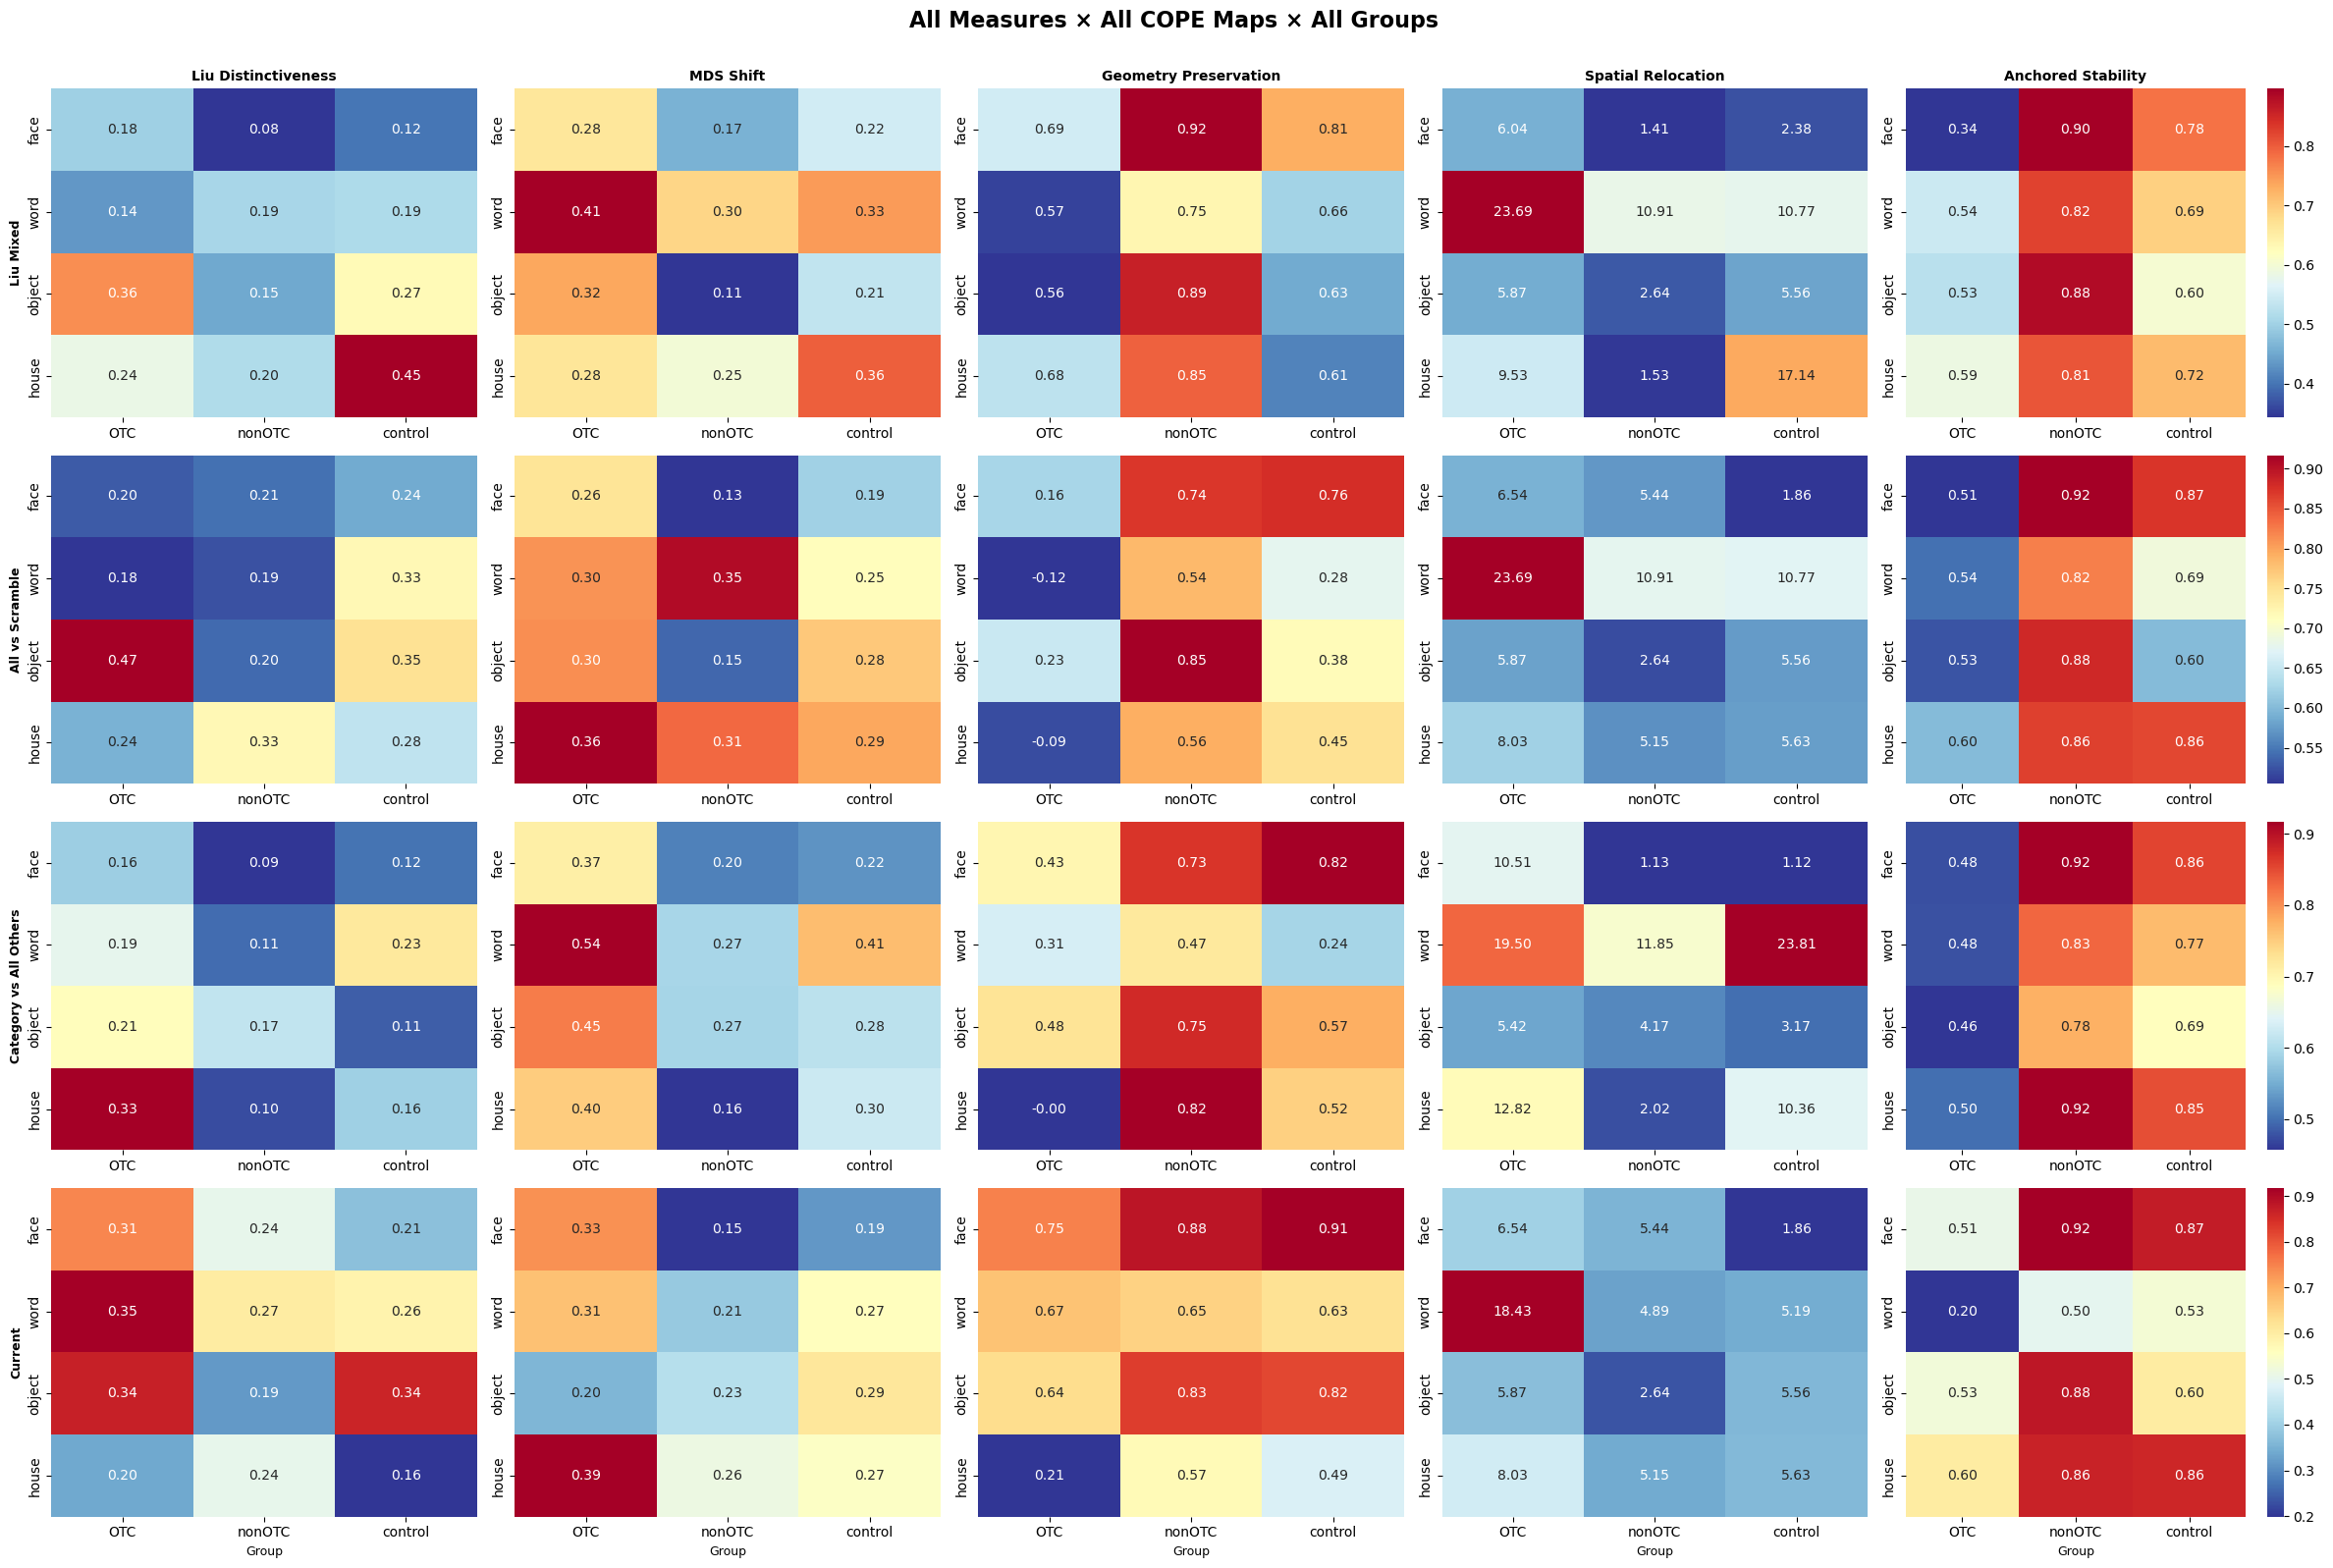


TREND ANALYSIS COMPLETE


In [49]:
# =============================================================================
# CELL 8: COMPREHENSIVE TREND COMPARISON - ALL CATEGORIES & GROUPS
# =============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE TREND COMPARISON - ALL CATEGORIES")
print("="*80)

# Create comprehensive summary
comprehensive_summary = []

for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
    print(f"\n{'='*80}")
    print(f"{cope_info['name']}")
    print(f"{'='*80}")
    
    for measure_key, column_name, measure_name, higher_is_change in measures_to_test:
        df_measure = all_results[cope_key][measure_key]
        
        # Handle different column names for MDS
        if measure_key == 'mds':
            category_col = 'roi_category'  # MDS uses roi_category
        else:
            category_col = 'category'  # Others use category
        
        print(f"\n{measure_name}:")
        print("-"*80)
        
        # BY CATEGORY
        print(f"\n{'Category':<10} {'OTC':>15} {'nonOTC':>15} {'Control':>15}")
        print("-"*55)
        
        for category in ['face', 'word', 'object', 'house']:
            otc_val = df_measure[(df_measure['group'] == 'OTC') & (df_measure[category_col] == category)][column_name].mean()
            nonotc_val = df_measure[(df_measure['group'] == 'nonOTC') & (df_measure[category_col] == category)][column_name].mean()
            ctrl_val = df_measure[(df_measure['group'] == 'control') & (df_measure[category_col] == category)][column_name].mean()
            
            print(f"{category.capitalize():<10} {otc_val:>15.3f} {nonotc_val:>15.3f} {ctrl_val:>15.3f}")
            
            # Store for CSV
            comprehensive_summary.append({
                'cope_map': cope_key,
                'cope_name': cope_info['name'],
                'measure': measure_name,
                'category': category,
                'OTC_mean': otc_val,
                'nonOTC_mean': nonotc_val,
                'control_mean': ctrl_val
            })
        
        # BY CATEGORY TYPE
        print(f"\n{'Type':<12} {'OTC':>15} {'nonOTC':>15} {'Control':>15}")
        print("-"*55)
        
        for cat_type in ['Bilateral', 'Unilateral']:
            otc_val = df_measure[(df_measure['group'] == 'OTC') & (df_measure['category_type'] == cat_type)][column_name].mean()
            nonotc_val = df_measure[(df_measure['group'] == 'nonOTC') & (df_measure['category_type'] == cat_type)][column_name].mean()
            ctrl_val = df_measure[(df_measure['group'] == 'control') & (df_measure['category_type'] == cat_type)][column_name].mean()
            
            print(f"{cat_type:<12} {otc_val:>15.3f} {nonotc_val:>15.3f} {ctrl_val:>15.3f}")

# Save comprehensive summary
comprehensive_df = pd.DataFrame(comprehensive_summary)
output_file = OUTPUT_DIR / 'comprehensive_category_trends.csv'
comprehensive_df.to_csv(output_file, index=False)
print(f"\n✓ Comprehensive trends saved to: {output_file}")

# =============================================================================
# CELL 9: SIDE-BY-SIDE PIVOT TABLES - Easy Visual Comparison
# =============================================================================

print("\n" + "="*80)
print("SIDE-BY-SIDE COMPARISON: LIU DISTINCTIVENESS (MOST IMPORTANT)")
print("="*80)

liu_data = comprehensive_df[comprehensive_df['measure'] == 'Liu Distinctiveness'].copy()

# For each group, show all categories across all cope maps
for group in ['OTC', 'nonOTC', 'control']:
    print(f"\n{group.upper()} - Liu Distinctiveness by Category:")
    print("-"*120)
    
    pivot = liu_data.pivot_table(
        index='category',
        columns='cope_map',
        values=f'{group}_mean'
    )
    
    # Rename columns to shorter names
    pivot.columns = ['All Others', 'All Scramble', 'Current Diff', 'Liu Mixed']
    pivot.index = [c.capitalize() for c in pivot.index]
    
    print(pivot.round(3))
    
    if group == 'OTC':
        print("\n  Key trend: Bilateral (object+house) > Unilateral (face+word)?")
        for cope in pivot.columns:
            obj_house = (pivot.loc['Object', cope] + pivot.loc['House', cope]) / 2
            face_word = (pivot.loc['Face', cope] + pivot.loc['Word', cope]) / 2
            status = "✓" if obj_house > face_word else "✗"
            print(f"    {cope}: Bil={obj_house:.3f}, Uni={face_word:.3f} {status}")

print("\n" + "="*80)



# =============================================================================
# CELL 10: VISUAL COMPARISON - Heatmaps
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("GENERATING VISUAL COMPARISON")
print("="*80)

fig, axes = plt.subplots(4, 5, figsize=(24, 16))

cope_keys = list(COPE_MAPS_TO_TEST.keys())
categories_order = ['face', 'word', 'object', 'house']

for col_idx, (measure_key, column_name, measure_name, _) in enumerate(measures_to_test):
    for row_idx, cope_key in enumerate(cope_keys):
        ax = axes[row_idx, col_idx]
        
        df_measure = all_results[cope_key][measure_key]
        
        # Handle different column names
        if measure_key == 'mds':
            category_col = 'roi_category'
        else:
            category_col = 'category'
        
        # Create pivot: categories × groups
        pivot = df_measure.pivot_table(
            index=category_col,
            columns='group',
            values=column_name,
            aggfunc='mean'
        )
        
        # Reorder
        pivot = pivot.reindex(index=categories_order, columns=['OTC', 'nonOTC', 'control'])
        
        # Plot heatmap
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlBu_r', 
                   ax=ax, cbar=col_idx == 4, vmin=pivot.min().min(), vmax=pivot.max().max())
        
        # Labels
        if row_idx == 0:
            ax.set_title(measure_name, fontweight='bold', fontsize=10)
        else:
            ax.set_title('')
        
        if col_idx == 0:
            cope_short = COPE_MAPS_TO_TEST[cope_key]['name'].split('(')[0].strip()
            ax.set_ylabel(cope_short, fontweight='bold', fontsize=9)
        else:
            ax.set_ylabel('')
        
        if row_idx == 3:
            ax.set_xlabel('Group', fontsize=9)
        else:
            ax.set_xlabel('')

plt.suptitle('All Measures × All COPE Maps × All Groups', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(OUTPUT_DIR / 'comprehensive_heatmap_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Heatmap saved: comprehensive_heatmap_comparison.png")
plt.show()

print("\n" + "="*80)
print("TREND ANALYSIS COMPLETE")
print("="*80)

In [50]:
# =============================================================================
# CELL 11: CLEAN TABULAR SUMMARY - ALL TRENDS
# =============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE TREND SUMMARY TABLE")
print("="*80)

summary_rows = []

for measure_key, column_name, measure_name, higher_is_change in measures_to_test:
    
    # Handle different column names
    category_col = 'roi_category' if measure_key == 'mds' else 'category'
    
    # Overall trend (all groups combined)
    overall_row = {'Measure': measure_name, 'Group': 'Overall'}
    
    for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
        df_measure = all_results[cope_key][measure_key]
        
        bil = df_measure[df_measure['category_type'] == 'Bilateral'][column_name]
        uni = df_measure[df_measure['category_type'] == 'Unilateral'][column_name]
        
        if len(bil) > 1 and len(uni) > 1:
            t_stat, p_val = ttest_ind(bil, uni)
            diff = bil.mean() - uni.mean()
            
            if higher_is_change:
                trend = "Bil>Uni" if diff > 0 else "Uni>Bil"
            else:
                trend = "Bil<Uni" if diff < 0 else "Uni<Bil"
            
            sig = "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            overall_row[cope_key] = f"{trend} p={p_val:.3f}{sig}"
        else:
            overall_row[cope_key] = "N/A"
    
    summary_rows.append(overall_row)
    
    # By group breakdown
    for group in ['OTC', 'nonOTC', 'control']:
        group_row = {'Measure': '', 'Group': f'  {group}'}
        
        for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
            df_measure = all_results[cope_key][measure_key]
            
            grp_data = df_measure[df_measure['group'] == group]
            bil = grp_data[grp_data['category_type'] == 'Bilateral'][column_name]
            uni = grp_data[grp_data['category_type'] == 'Unilateral'][column_name]
            
            if len(bil) > 1 and len(uni) > 1:
                t_stat, p_val = ttest_ind(bil, uni)
                diff = bil.mean() - uni.mean()
                
                if higher_is_change:
                    trend = "Bil>Uni" if diff > 0 else "Uni>Bil"
                else:
                    trend = "Bil<Uni" if diff < 0 else "Uni<Bil"
                
                sig = "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                group_row[cope_key] = f"{trend} p={p_val:.3f}{sig}"
            else:
                group_row[cope_key] = "N/A"
        
        summary_rows.append(group_row)

# Create DataFrame
summary_table = pd.DataFrame(summary_rows)

# Rename columns for clarity
summary_table = summary_table.rename(columns={
    'liu_mixed': 'Liu Mixed',
    'all_scramble': 'All Scramble',
    'all_vs_others': 'All vs Others',
    'current_differential': 'Current Diff'
})

# Print table
print("\nLegend: ** p<0.01, * p<0.05")
print("Bil>Uni = Bilateral shows more change than Unilateral (for 'higher=change' measures)")
print("Bil<Uni = Bilateral shows less change than Unilateral (for 'lower=change' measures)")
print("\n" + summary_table.to_string(index=False))

# Save
output_file = OUTPUT_DIR / 'trend_summary_table.csv'
summary_table.to_csv(output_file, index=False)
print(f"\n✓ Saved to: {output_file}")

print("\n" + "="*80)
print("TABLE COMPLETE")
print("="*80)


COMPREHENSIVE TREND SUMMARY TABLE

Legend: ** p<0.01, * p<0.05
Bil>Uni = Bilateral shows more change than Unilateral (for 'higher=change' measures)
Bil<Uni = Bilateral shows less change than Unilateral (for 'lower=change' measures)

              Measure     Group         Liu Mixed    All Scramble   All vs Others     Current Diff
  Liu Distinctiveness   Overall Bil>Uni p=0.001** Bil>Uni p=0.111 Bil>Uni p=0.640  Uni>Bil p=0.691
                            OTC  Bil>Uni p=0.010* Bil>Uni p=0.066 Bil>Uni p=0.062  Uni>Bil p=0.463
                         nonOTC   Bil>Uni p=0.470 Bil>Uni p=0.345 Bil>Uni p=0.438  Uni>Bil p=0.562
                        control Bil>Uni p=0.007** Bil>Uni p=0.651 Uni>Bil p=0.286  Bil>Uni p=0.831
            MDS Shift   Overall   Uni>Bil p=0.649 Bil>Uni p=0.182 Uni>Bil p=0.616  Bil>Uni p=0.239
                            OTC   Uni>Bil p=0.523 Bil>Uni p=0.429 Uni>Bil p=0.816  Uni>Bil p=0.778
                         nonOTC   Uni>Bil p=0.444 Uni>Bil p=0.907 Uni>Bil

In [51]:
# =============================================================================
# CELL 11: REORGANIZED TREND SUMMARY - ONE TABLE PER MEASURE
# =============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE TREND SUMMARY - REORGANIZED")
print("="*80)
print("\nLegend: ** p<0.01, * p<0.05")
print("For 'higher=change' measures: Bil>Uni means bilateral changes more")
print("For 'lower=change' measures: Bil<Uni means bilateral changes more\n")

all_summaries = {}

for measure_key, column_name, measure_name, higher_is_change in measures_to_test:
    
    # Handle different column names
    category_col = 'roi_category' if measure_key == 'mds' else 'category'
    
    measure_summary = []
    
    for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
        df_measure = all_results[cope_key][measure_key]
        
        row_data = {'COPE_Map': cope_info['name'].split('(')[0].strip()}
        
        # Overall
        bil_all = df_measure[df_measure['category_type'] == 'Bilateral'][column_name]
        uni_all = df_measure[df_measure['category_type'] == 'Unilateral'][column_name]
        
        if len(bil_all) > 1 and len(uni_all) > 1:
            t_stat, p_val = ttest_ind(bil_all, uni_all)
            diff = bil_all.mean() - uni_all.mean()
            
            if higher_is_change:
                trend = "Bil>Uni" if diff > 0 else "Uni>Bil"
            else:
                trend = "Bil<Uni" if diff < 0 else "Uni<Bil"
            
            sig = "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            row_data['Overall'] = f"{trend} ({p_val:.3f}){sig}"
        else:
            row_data['Overall'] = "N/A"
        
        # By group
        for group in ['OTC', 'nonOTC', 'control']:
            grp_data = df_measure[df_measure['group'] == group]
            bil = grp_data[grp_data['category_type'] == 'Bilateral'][column_name]
            uni = grp_data[grp_data['category_type'] == 'Unilateral'][column_name]
            
            if len(bil) > 1 and len(uni) > 1:
                t_stat, p_val = ttest_ind(bil, uni)
                diff = bil.mean() - uni.mean()
                
                if higher_is_change:
                    trend = "Bil>Uni" if diff > 0 else "Uni>Bil"
                else:
                    trend = "Bil<Uni" if diff < 0 else "Uni<Bil"
                
                sig = "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                row_data[group] = f"{trend} ({p_val:.3f}){sig}"
            else:
                row_data[group] = "N/A"
        
        measure_summary.append(row_data)
    
    all_summaries[measure_name] = pd.DataFrame(measure_summary)

# Print each measure separately
for measure_name, df_summary in all_summaries.items():
    print("\n" + "="*80)
    print(f"{measure_name.upper()}")
    print("="*80)
    print(df_summary.to_string(index=False))

# Save all summaries
for measure_name, df_summary in all_summaries.items():
    safe_name = measure_name.replace(' ', '_').lower()
    output_file = OUTPUT_DIR / f'trend_{safe_name}.csv'
    df_summary.to_csv(output_file, index=False)

print("\n" + "="*80)
print("SUMMARY TABLES COMPLETE")
print("="*80)
print(f"\n✓ All tables saved to: {OUTPUT_DIR}")


COMPREHENSIVE TREND SUMMARY - REORGANIZED

Legend: ** p<0.01, * p<0.05
For 'higher=change' measures: Bil>Uni means bilateral changes more
For 'lower=change' measures: Bil<Uni means bilateral changes more


LIU DISTINCTIVENESS
              COPE_Map           Overall              OTC          nonOTC           control
             Liu Mixed Bil>Uni (0.001)** Bil>Uni (0.010)* Bil>Uni (0.470) Bil>Uni (0.007)**
       All vs Scramble   Bil>Uni (0.111)  Bil>Uni (0.066) Bil>Uni (0.345)   Bil>Uni (0.651)
Category vs All Others   Bil>Uni (0.640)  Bil>Uni (0.062) Bil>Uni (0.438)   Uni>Bil (0.286)
               Current   Uni>Bil (0.691)  Uni>Bil (0.463) Uni>Bil (0.562)   Bil>Uni (0.831)

MDS SHIFT
              COPE_Map         Overall             OTC          nonOTC         control
             Liu Mixed Uni>Bil (0.649) Uni>Bil (0.523) Uni>Bil (0.444) Bil>Uni (0.879)
       All vs Scramble Bil>Uni (0.182) Bil>Uni (0.429) Uni>Bil (0.907) Bil>Uni (0.058)
Category vs All Others Uni>Bil (0.616) Un

In [53]:
# =============================================================================
# CELL 11: CATEGORY-SPECIFIC BREAKDOWN - WHICH COPES, WHICH VALUES
# =============================================================================

print("\n" + "="*80)
print("CATEGORY-SPECIFIC COPE BREAKDOWN")
print("="*80)

for category in ['face', 'word', 'object', 'house']:
    print("\n" + "="*80)
    print(f"{category.upper()}")
    print("="*80)
    
    # Show which cope is used in each scheme
    print("\nCOPE Contrasts Used:")
    for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
        cope_num, mult = cope_info['map'][category]
        sign = "×(+1)" if mult > 0 else "×(-1)"
        
        # Get contrast name
        contrast_names = {
            1: "Face>Object", 2: "House>Object", 3: "Object>Scramble", 4: "Word>Object",
            6: "Face>All", 7: "House>All", 8: "Object>All", 9: "Word>All",
            10: "Face>Scramble", 11: "House>Scramble", 12: "Word>Scramble", 13: "Face>Word"
        }
        contrast = contrast_names.get(cope_num, f"cope{cope_num}")
        
        scheme_name = cope_info['name'].split('(')[0].strip()
        print(f"  {scheme_name:<20}: cope{cope_num:2d} {sign} = {contrast}")
    
    # Now show values for each measure
    print("\n" + "-"*80)
    print("RESULTS BY MEASURE:")
    print("-"*80)
    
    category_col_dict = {m[0]: 'roi_category' if m[0] == 'mds' else 'category' for m in measures_to_test}
    
    for measure_key, column_name, measure_name, higher_is_change in measures_to_test:
        print(f"\n  {measure_name}:")
        
        category_col = category_col_dict[measure_key]
        
        # Create comparison table
        print(f"    {'COPE Map':<20} {'OTC':>12} {'nonOTC':>12} {'control':>12}")
        print(f"    {'-'*58}")
        
        for cope_key, cope_info in COPE_MAPS_TO_TEST.items():
            df_measure = all_results[cope_key][measure_key]
            cat_data = df_measure[df_measure[category_col] == category]
            
            scheme_short = cope_info['name'].split('(')[0].strip()
            
            otc_mean = cat_data[cat_data['group'] == 'OTC'][column_name].mean()
            nonotc_mean = cat_data[cat_data['group'] == 'nonOTC'][column_name].mean()
            ctrl_mean = cat_data[cat_data['group'] == 'control'][column_name].mean()
            
            otc_str = f"{otc_mean:.3f}" if not np.isnan(otc_mean) else "N/A"
            nonotc_str = f"{nonotc_mean:.3f}" if not np.isnan(nonotc_mean) else "N/A"
            ctrl_str = f"{ctrl_mean:.3f}" if not np.isnan(ctrl_mean) else "N/A"
            
            print(f"    {scheme_short:<20} {otc_str:>12} {nonotc_str:>12} {ctrl_str:>12}")

print("\n" + "="*80)
print("CATEGORY BREAKDOWN COMPLETE")
print("="*80)


CATEGORY-SPECIFIC COPE BREAKDOWN

FACE

COPE Contrasts Used:
  Liu Mixed           : cope 1 ×(+1) = Face>Object
  All vs Scramble     : cope10 ×(+1) = Face>Scramble
  Category vs All Others: cope 6 ×(+1) = Face>All
  Current             : cope10 ×(+1) = Face>Scramble

--------------------------------------------------------------------------------
RESULTS BY MEASURE:
--------------------------------------------------------------------------------

  Liu Distinctiveness:
    COPE Map                      OTC       nonOTC      control
    ----------------------------------------------------------
    Liu Mixed                   0.183        0.078        0.118
    All vs Scramble             0.197        0.207        0.236
    Category vs All Others        0.159        0.094        0.117
    Current                     0.306        0.241        0.206

  MDS Shift:
    COPE Map                      OTC       nonOTC      control
    ---------------------------------------------------------


VISUALIZING ALL SCRAMBLE SCHEME - 3 KEY MEASURES
✓ Plot saved: all_scramble_3measures_by_category.png


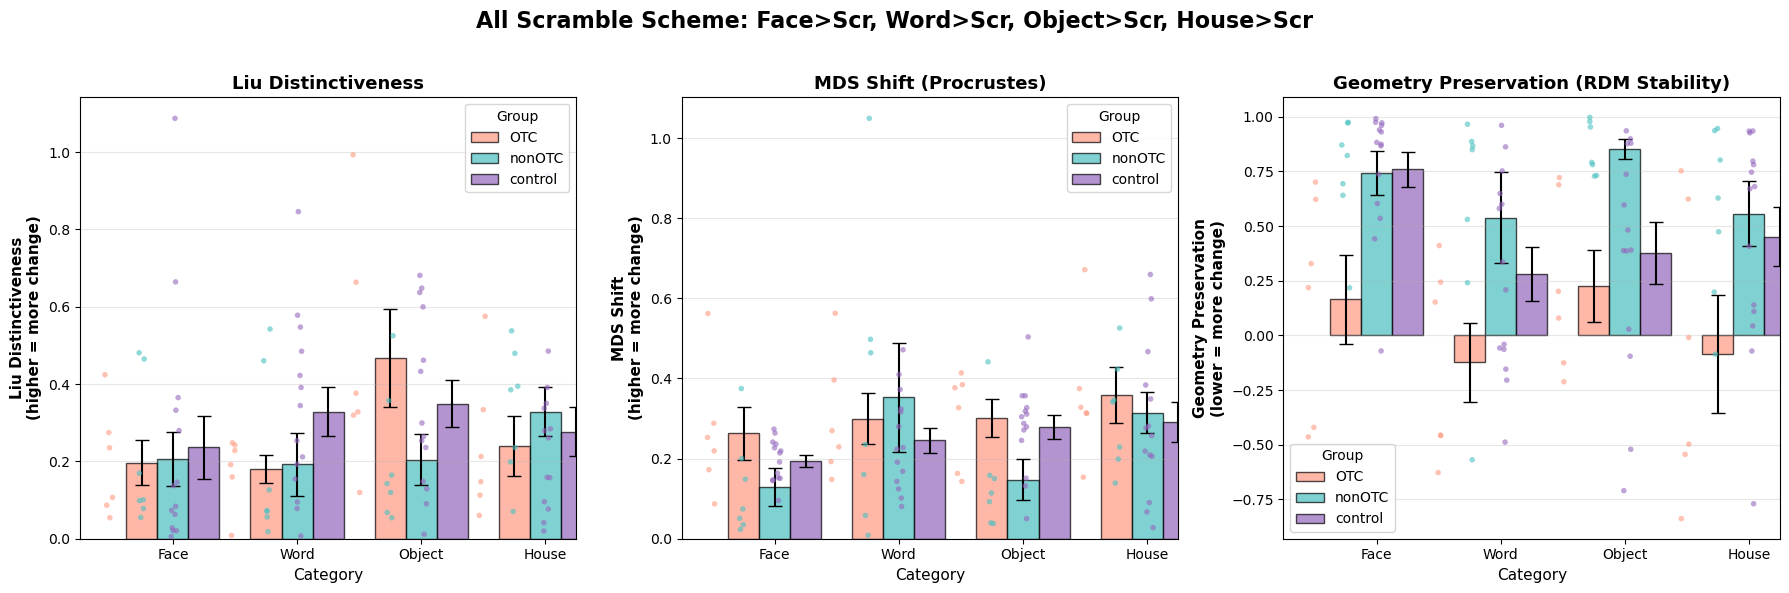


ALL SCRAMBLE - DETAILED STATISTICS BY CATEGORY

Liu Distinctiveness:
--------------------------------------------------------------------------------
Category   Group            Mean        Std      N
--------------------------------------------------
Face       OTC             0.197      0.141      6
Face       nonOTC          0.207      0.185      7
Face       control         0.236      0.307     14
Word       OTC             0.180      0.090      6
Word       nonOTC          0.193      0.215      7
Word       control         0.329      0.233     14
Object     OTC             0.467      0.312      6
Object     nonOTC          0.204      0.173      7
Object     control         0.350      0.226     14
House      OTC             0.240      0.189      6
House      nonOTC          0.329      0.166      7
House      control         0.277      0.237     14

MDS Shift:
--------------------------------------------------------------------------------
Category   Group            Mean        St

In [55]:
# =============================================================================
# CELL 12: ALL SCRAMBLE - 3 PANELS (ONE PER MEASURE)
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("VISUALIZING ALL SCRAMBLE SCHEME - 3 KEY MEASURES")
print("="*80)

# Extract All Scramble results
liu_df = all_results['all_scramble']['liu']
mds_df = all_results['all_scramble']['mds']
geo_df = all_results['all_scramble']['geometry']

# Handle MDS column name
mds_df = mds_df.rename(columns={'roi_category': 'category'})

# Set up plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
categories = ['face', 'word', 'object', 'house']
groups = ['OTC', 'nonOTC', 'control']
group_colors = {'OTC': '#ff9b83', 'nonOTC': '#4ac0c0', 'control': '#9467bd'}

# Panel 1: Liu Distinctiveness
ax = axes[0]
summary_liu = liu_df.groupby(['group', 'category'])['liu_distinctiveness'].agg(['mean', 'sem']).reset_index()

x = np.arange(len(categories))
width = 0.25

for i, group in enumerate(groups):
    grp_data = summary_liu[summary_liu['group'] == group]
    grp_data['category'] = pd.Categorical(grp_data['category'], categories=categories, ordered=True)
    grp_data = grp_data.sort_values('category')
    
    ax.bar(x + i*width, grp_data['mean'], width, yerr=grp_data['sem'],
          label=group, color=group_colors[group], alpha=0.7, capsize=5, 
          edgecolor='black', linewidth=1)

# Overlay points
sns.stripplot(data=liu_df, x='category', y='liu_distinctiveness', hue='group',
             order=categories, hue_order=groups, palette=group_colors, 
             dodge=True, ax=ax, size=4, alpha=0.6, legend=False)

ax.set_ylabel('Liu Distinctiveness\n(higher = more change)', fontsize=11, fontweight='bold')
ax.set_xlabel('Category', fontsize=11)
ax.set_title('Liu Distinctiveness', fontsize=13, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels([c.capitalize() for c in categories])
ax.legend(title='Group', fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Panel 2: MDS Shift
ax = axes[1]
summary_mds = mds_df.groupby(['group', 'category'])['mds_shift'].agg(['mean', 'sem']).reset_index()

for i, group in enumerate(groups):
    grp_data = summary_mds[summary_mds['group'] == group]
    grp_data['category'] = pd.Categorical(grp_data['category'], categories=categories, ordered=True)
    grp_data = grp_data.sort_values('category')
    
    ax.bar(x + i*width, grp_data['mean'], width, yerr=grp_data['sem'],
          label=group, color=group_colors[group], alpha=0.7, capsize=5,
          edgecolor='black', linewidth=1)

sns.stripplot(data=mds_df, x='category', y='mds_shift', hue='group',
             order=categories, hue_order=groups, palette=group_colors,
             dodge=True, ax=ax, size=4, alpha=0.6, legend=False)

ax.set_ylabel('MDS Shift\n(higher = more change)', fontsize=11, fontweight='bold')
ax.set_xlabel('Category', fontsize=11)
ax.set_title('MDS Shift (Procrustes)', fontsize=13, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels([c.capitalize() for c in categories])
ax.legend(title='Group', fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Panel 3: Geometry Preservation
ax = axes[2]
summary_geo = geo_df.groupby(['group', 'category'])['geometry_preservation'].agg(['mean', 'sem']).reset_index()

for i, group in enumerate(groups):
    grp_data = summary_geo[summary_geo['group'] == group]
    grp_data['category'] = pd.Categorical(grp_data['category'], categories=categories, ordered=True)
    grp_data = grp_data.sort_values('category')
    
    ax.bar(x + i*width, grp_data['mean'], width, yerr=grp_data['sem'],
          label=group, color=group_colors[group], alpha=0.7, capsize=5,
          edgecolor='black', linewidth=1)

sns.stripplot(data=geo_df, x='category', y='geometry_preservation', hue='group',
             order=categories, hue_order=groups, palette=group_colors,
             dodge=True, ax=ax, size=4, alpha=0.6, legend=False)

ax.set_ylabel('Geometry Preservation\n(lower = more change)', fontsize=11, fontweight='bold')
ax.set_xlabel('Category', fontsize=11)
ax.set_title('Geometry Preservation (RDM Stability)', fontsize=13, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels([c.capitalize() for c in categories])
ax.legend(title='Group', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('All Scramble Scheme: Face>Scr, Word>Scr, Object>Scr, House>Scr', 
            fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(OUTPUT_DIR / 'all_scramble_3measures_by_category.png', dpi=300, bbox_inches='tight')
print("✓ Plot saved: all_scramble_3measures_by_category.png")
plt.show()

# Print detailed statistics
print("\n" + "="*80)
print("ALL SCRAMBLE - DETAILED STATISTICS BY CATEGORY")
print("="*80)

for measure_name, df, col in [
    ('Liu Distinctiveness', liu_df, 'liu_distinctiveness'),
    ('MDS Shift', mds_df, 'mds_shift'),
    ('Geometry Preservation', geo_df, 'geometry_preservation')
]:
    print(f"\n{measure_name}:")
    print("-"*80)
    print(f"{'Category':<10} {'Group':<10} {'Mean':>10} {'Std':>10} {'N':>6}")
    print("-"*50)
    
    for category in categories:
        for group in groups:
            cat_grp = df[(df['category'] == category) & (df['group'] == group)]
            if len(cat_grp) > 0:
                mean_val = cat_grp[col].mean()
                std_val = cat_grp[col].std()
                n = len(cat_grp)
                print(f"{category.capitalize():<10} {group:<10} {mean_val:>10.3f} {std_val:>10.3f} {n:>6}")


VISUALIZING ALL SCRAMBLE SCHEME - HEMISPHERE BREAKDOWN
✓ Plot saved: all_scramble_hemisphere_breakdown.png


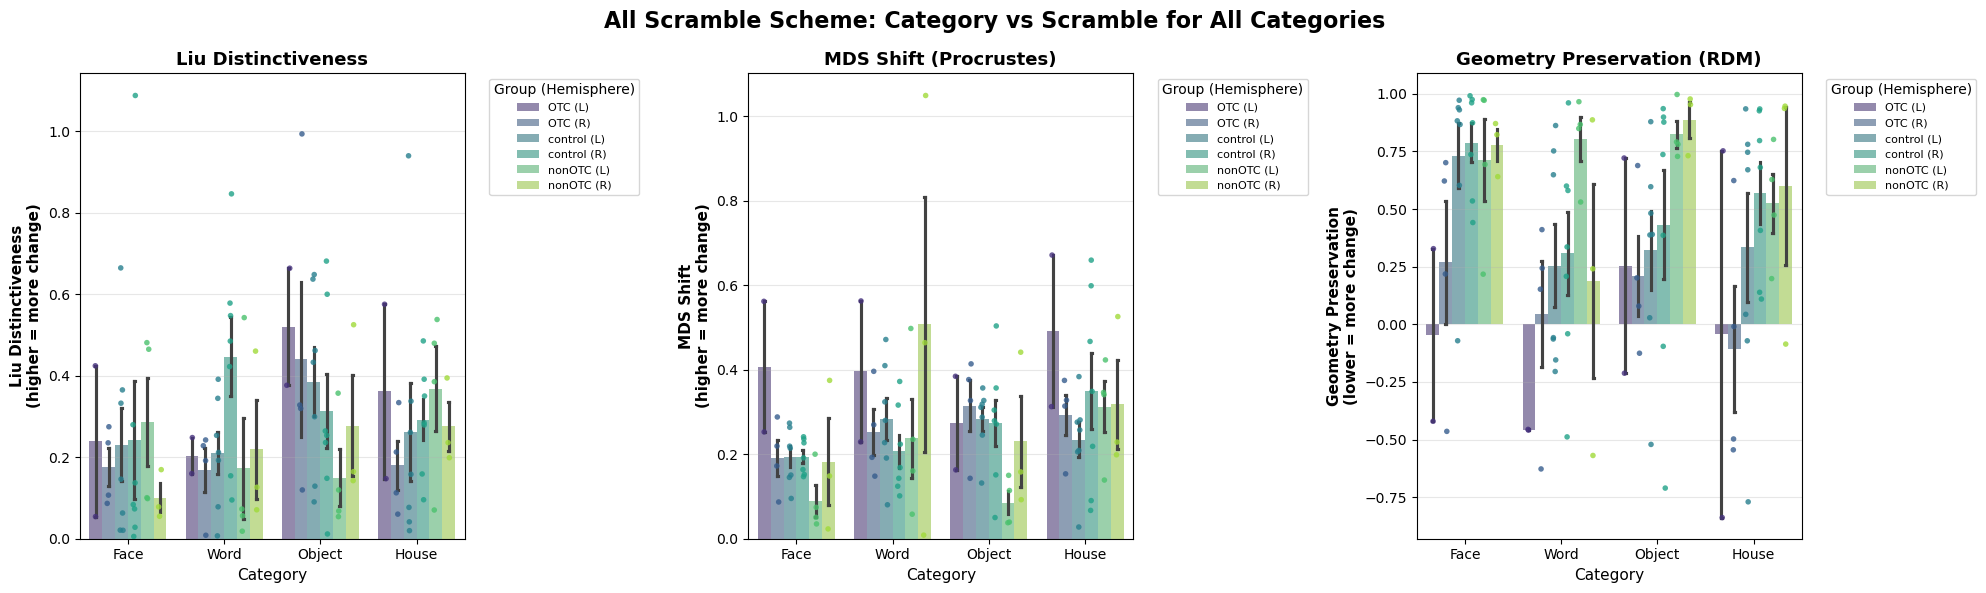

In [56]:
# =============================================================================
# CELL 12: ALL SCRAMBLE - 3 MEASURES WITH HEMISPHERE BREAKDOWN
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("VISUALIZING ALL SCRAMBLE SCHEME - HEMISPHERE BREAKDOWN")
print("="*80)

# Extract All Scramble results
liu_df = all_results['all_scramble']['liu'].copy()
mds_df = all_results['all_scramble']['mds'].copy()
geo_df = all_results['all_scramble']['geometry'].copy()

# Handle MDS column name
mds_df = mds_df.rename(columns={'roi_category': 'category'})

# Create hemisphere-based grouping for all dataframes
for df in [liu_df, mds_df, geo_df]:
    df['Group_Hemi'] = df['group'] + ' (' + df['hemi'].str.upper() + ')'

# Set up plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
categories = ['face', 'word', 'object', 'house']

# Define order and colors
hue_order = sorted(liu_df['Group_Hemi'].unique())
colors = sns.color_palette("viridis", n_colors=len(hue_order))

# Panel 1: Liu Distinctiveness
ax = axes[0]
sns.barplot(data=liu_df, x='category', y='liu_distinctiveness', hue='Group_Hemi',
           order=categories, hue_order=hue_order, palette=colors, 
           alpha=0.6, errorbar='se', capsize=0.05, ax=ax)

sns.stripplot(data=liu_df, x='category', y='liu_distinctiveness', hue='Group_Hemi',
             order=categories, hue_order=hue_order, palette=colors,
             dodge=True, ax=ax, size=4, alpha=0.8, legend=False)

ax.set_ylabel('Liu Distinctiveness\n(higher = more change)', fontsize=11, fontweight='bold')
ax.set_xlabel('Category', fontsize=11)
ax.set_title('Liu Distinctiveness', fontsize=13, fontweight='bold')
ax.set_xticklabels([c.capitalize() for c in categories])
ax.legend(title='Group (Hemisphere)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(axis='y', alpha=0.3)

# Panel 2: MDS Shift
ax = axes[1]
sns.barplot(data=mds_df, x='category', y='mds_shift', hue='Group_Hemi',
           order=categories, hue_order=hue_order, palette=colors,
           alpha=0.6, errorbar='se', capsize=0.05, ax=ax)

sns.stripplot(data=mds_df, x='category', y='mds_shift', hue='Group_Hemi',
             order=categories, hue_order=hue_order, palette=colors,
             dodge=True, ax=ax, size=4, alpha=0.8, legend=False)

ax.set_ylabel('MDS Shift\n(higher = more change)', fontsize=11, fontweight='bold')
ax.set_xlabel('Category', fontsize=11)
ax.set_title('MDS Shift (Procrustes)', fontsize=13, fontweight='bold')
ax.set_xticklabels([c.capitalize() for c in categories])
ax.legend(title='Group (Hemisphere)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(axis='y', alpha=0.3)

# Panel 3: Geometry Preservation
ax = axes[2]
sns.barplot(data=geo_df, x='category', y='geometry_preservation', hue='Group_Hemi',
           order=categories, hue_order=hue_order, palette=colors,
           alpha=0.6, errorbar='se', capsize=0.05, ax=ax)

sns.stripplot(data=geo_df, x='category', y='geometry_preservation', hue='Group_Hemi',
             order=categories, hue_order=hue_order, palette=colors,
             dodge=True, ax=ax, size=4, alpha=0.8, legend=False)

ax.set_ylabel('Geometry Preservation\n(lower = more change)', fontsize=11, fontweight='bold')
ax.set_xlabel('Category', fontsize=11)
ax.set_title('Geometry Preservation (RDM)', fontsize=13, fontweight='bold')
ax.set_xticklabels([c.capitalize() for c in categories])
ax.legend(title='Group (Hemisphere)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('All Scramble Scheme: Category vs Scramble for All Categories', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_scramble_hemisphere_breakdown.png', dpi=300, bbox_inches='tight')
print("✓ Plot saved: all_scramble_hemisphere_breakdown.png")
plt.show()

In [64]:
# =============================================================================
# CELL 12: PLOTNINE - CONTROLS VIOLIN + OTC INDIVIDUAL POINTS
# =============================================================================

from plotnine import *
import pandas as pd
import numpy as np

print("\n" + "="*80)
print("CREATING PLOTNINE PLOTS - ALL SCRAMBLE SCHEME")
print("="*80)

# Extract All Scramble results
liu_df = all_results['all_scramble']['liu'].copy()
mds_df = all_results['all_scramble']['mds'].copy()
geo_df = all_results['all_scramble']['geometry'].copy()

mds_df = mds_df.rename(columns={'roi_category': 'category'})

# Create labels
for df in [liu_df, mds_df, geo_df]:
    df['sub_code'] = df.apply(
        lambda row: f"{row['hemi'].upper()}{row['code'].replace('OTC', '')}" if row['group'] == 'OTC' else row['code'],
        axis=1
    )
    df['hemi_cap'] = df['hemi'].str.capitalize()

def create_category_plot(df, measure_col, measure_name, category, output_name):
    """Create plot for one category"""
    
    cat_data = df[df['category'] == category].copy()
    ctrl = cat_data[cat_data['group'] == 'control'].copy()
    otc = cat_data[cat_data['group'] == 'OTC'].copy()
    
    # Plot
    seed = 2
    p = ggplot(ctrl, aes(x='factor(1)', y=measure_col, fill='hemi_cap')) + \
        geom_violin(alpha=0.3, position=position_dodge(0.9)) + \
        geom_jitter(ctrl, aes(x='factor(1)', y=measure_col, fill='hemi_cap'), 
                   shape='o', size=2, alpha=0.5,
                   position=position_jitterdodge(dodge_width=0.9, jitter_width=0.15, random_state=seed)) + \
        geom_point(otc, aes(x='factor(1)', y=measure_col, fill='hemi_cap'),
                  shape='o', size=5, alpha=0.9, stroke=0.5,
                  position=position_jitterdodge(dodge_width=0.9, jitter_width=0.15, random_state=seed)) + \
        geom_label(otc, aes(x='factor(1)', y=measure_col, label='sub_code', fill='hemi_cap'), 
                  position=position_jitterdodge(dodge_width=0.9, jitter_width=0.15, random_state=seed), 
                  size=7, color='white', fontweight='bold') + \
        scale_fill_manual(values=['#ee7183', '#7398af'], labels=['Left', 'Right']) + \
        xlab('') + ylab(measure_name) + \
        ggtitle(category.capitalize()) + \
        theme_classic() + \
        theme(
            text=element_text(color='black'),
            axis_text_y=element_text(size=12),
            axis_title=element_text(size=14),
            axis_line=element_line(),
            legend_position='bottom',
            legend_title=element_text(size=10),
            panel_border=element_blank(),
            figure_size=(3, 5),
            axis_line_x=element_blank(),
            axis_text_x=element_blank(),
            axis_ticks_major_x=element_blank(),
            axis_title_x=element_blank()
        ) + \
        labs(fill='Hemisphere')
    
    filename = f'{output_name}_{category}.png'
    p.save(f'{OUTPUT_DIR}/{filename}', width=3, height=5, dpi=300)
    print(f"  ✓ Saved {filename}")
    
    return p

# Create all plots
for cat in ['face', 'word', 'object', 'house']:
    print(f"\n{cat.upper()}:")
    create_category_plot(liu_df, 'liu_distinctiveness', 'Liu Distinctiveness', cat, 'liu')
    create_category_plot(mds_df, 'mds_shift', 'MDS Shift', cat, 'mds')
    create_category_plot(geo_df, 'geometry_preservation', 'Geometry Preservation', cat, 'geo')

print("\n✓ All plotnine plots saved to:", OUTPUT_DIR)


CREATING PLOTNINE PLOTS - ALL SCRAMBLE SCHEME

FACE:
  ✓ Saved liu_face.png
  ✓ Saved mds_face.png
  ✓ Saved geo_face.png

WORD:
  ✓ Saved liu_word.png
  ✓ Saved mds_word.png
  ✓ Saved geo_word.png

OBJECT:
  ✓ Saved liu_object.png
  ✓ Saved mds_object.png
  ✓ Saved geo_object.png

HOUSE:
  ✓ Saved liu_house.png
  ✓ Saved mds_house.png
  ✓ Saved geo_house.png

✓ All plotnine plots saved to: /user_data/csimmon2/long_pt/cope_map_comparison


In [67]:
# =============================================================================
# CELL 13: PLOTNINE PLOTS - SUM SELECTIVITY & MEAN ACTIVATION
# =============================================================================

from plotnine import *

print("\n" + "="*80)
print("CREATING PLOTNINE PLOTS - SUM SELECTIVITY & MEAN ACTIVATION")
print("="*80)

# Extract All Scramble results
sumsel_df = all_results['all_scramble']['sum_selectivity'].copy()

# Create labels
sumsel_df['sub_code'] = sumsel_df.apply(
    lambda row: f"{row['hemi'].upper()}{row['code'].replace('OTC', '')}" if row['group'] == 'OTC' else row['code'],
    axis=1
)
sumsel_df['hemi_cap'] = sumsel_df['hemi'].str.capitalize()

def create_category_plot(df, measure_col, measure_name, category, output_name):
    cat_data = df[df['category'] == category].copy()
    ctrl = cat_data[cat_data['group'] == 'control'].copy()
    otc = cat_data[cat_data['group'] == 'OTC'].copy()
    
    seed = 2
    p = ggplot(ctrl, aes(x='factor(1)', y=measure_col, fill='hemi_cap')) + \
        geom_violin(alpha=0.3, position=position_dodge(0.9)) + \
        geom_jitter(ctrl, aes(x='factor(1)', y=measure_col, fill='hemi_cap'), 
                   shape='o', size=2, alpha=0.5,
                   position=position_jitterdodge(dodge_width=0.9, jitter_width=0.15, random_state=seed)) + \
        geom_point(otc, aes(x='factor(1)', y=measure_col, fill='hemi_cap'),
                  shape='o', size=5, alpha=0.9, stroke=0.5,
                  position=position_jitterdodge(dodge_width=0.9, jitter_width=0.15, random_state=seed)) + \
        geom_label(otc, aes(x='factor(1)', y=measure_col, label='sub_code', fill='hemi_cap'), 
                  position=position_jitterdodge(dodge_width=0.9, jitter_width=0.15, random_state=seed), 
                  size=7, color='white', fontweight='bold') + \
        scale_fill_manual(values=['#ee7183', '#7398af'], labels=['Left', 'Right']) + \
        xlab('') + ylab(measure_name) + ggtitle(category.capitalize()) + \
        theme_classic() + \
        theme(text=element_text(color='black'), axis_text_y=element_text(size=12),
              axis_title=element_text(size=14), axis_line=element_line(),
              legend_position='bottom', legend_title=element_text(size=10),
              panel_border=element_blank(), figure_size=(3, 5),
              axis_line_x=element_blank(), axis_text_x=element_blank(),
              axis_ticks_major_x=element_blank(), axis_title_x=element_blank()) + \
        labs(fill='Hemisphere')
    
    filename = f'{output_name}_{category}.png'
    p.save(f'{OUTPUT_DIR}/{filename}', width=3, height=5, dpi=300)
    print(f"  ✓ {filename}")

# Create plots for both measures
for cat in ['face', 'word', 'object', 'house']:
    print(f"\n{cat.upper()}:")
    create_category_plot(sumsel_df, 'sum_selectivity', 'Sum Selectivity', cat, 'sumsel')
    create_category_plot(sumsel_df, 'mean_activation', 'Mean Activation', cat, 'meanact')

print("\n✓ All sum selectivity and mean activation plots saved to:", OUTPUT_DIR)


CREATING PLOTNINE PLOTS - SUM SELECTIVITY & MEAN ACTIVATION

FACE:
  ✓ sumsel_face.png
  ✓ meanact_face.png

WORD:
  ✓ sumsel_word.png
  ✓ meanact_word.png

OBJECT:
  ✓ sumsel_object.png
  ✓ meanact_object.png

HOUSE:
  ✓ sumsel_house.png
  ✓ meanact_house.png

✓ All sum selectivity and mean activation plots saved to: /user_data/csimmon2/long_pt/cope_map_comparison
